# 2. Pre-processing

> Author: *Valentin Christiaens*  
> Suitable for VIP *v1.1.3* onwards  
> Last update: *2022/03/25*

**Table of contents**

* [2.1. Recentering coronagraphic NACO data](#2.1.-Recentering-coronagraphic-NACO-data)
    - [2.1.1. Loading the data](#2.1.1.-Loading-the-data)
    - [2.1.2. Recentering with individual 2D negative Gaussian fits](#2.1.2.-Recentering-with-individual-2D-negative-Gaussian-fits)
    - [2.1.3. Recentering with cross-correlation + 2D negGaussian](#2.1.3.-Recentering-with-cross-correlation-+-2D-negGaussian)
    - [2.1.4. Recentering with iterative speckle cross-correlation + 2D negGaussian](#2.1.4.-Recentering-with-iterative-speckle-cross-correlation-+-2D-negGaussian)
    - [2.1.5. Validation of the best recentering method](#2.1.5.-Validation-of-the-best-recentering-method)    
    - [2.1.6. Bad frame trimming](#2.1.6.-Bad-frame-trimming) 
   
* [2.2. Recentering coronagraphic SPHERE/IFS data](#2.2.-Recentering-coronagraphic-SPHERE/IFS-data)
    - [2.2.1. Loading the data](#2.2.1.-Loading-the-data)
    - [2.2.2. Replacing NaN values](#2.2.2.-Replacing-NaN-values)
    - [2.2.3. Bad pixel correction](#2.2.3.-Bad-pixel-correction)
    - [2.2.4. Background-star removal](#2.2.4.-Background-star-removal)
    - [2.2.5. Satellite-spot based recentering](#2.2.5.-Satellite-spot-based-recentering)
    - [2.2.6. Radon-transform based recentering](#2.2.6.-Radon-transform-based-recentering)
    
* [2.3. Pre-processing a SINFONI datacube](#2.3.-Pre-processing-a-SINFONI-datacube)
    - [2.3.1. Loading the data](#2.3.1.-Loading-the-data)
    - [2.3.2. Measuring the FWHM](#2.3.2.-Measuring-the-FWHM)
    - [2.3.3. Bad pixel correction](#2.3.3.-Bad-pixel-correction)
    - [2.3.4. Vertical resampling](#2.3.4.-Vertical-resampling)
    - [2.3.5. Recentering with 2D Gaussian fits](#2.3.5.-Recentering-with-2D-Gaussian-fits)

The subpackage ``preproc`` contains all sorts of low-level image transformation routines: translation, rotation, cropping, pixel resampling, etc. It also contains functions dedicated to the preparation of 3D or 4D arrays before stellar halo modeling and subtraction (i.e. post-processing). In this tutorial we'll show how to use some of these pre-processing routines to perform the following tasks: 
- recentering a NACO L' coronagraphic dataset and trimming bad frames out;
- correcting bad pixels from a SPHERE/IFS coronagraphic datacube and recentering it; 
- perform a "full pre-processing" of non-coronagraphic SINFONI data on HD 179218.

It is recommended to perform (low-level) calibration tasks such as dark subtraction or flat-fielding using the observatory pipeline of the respective instrument the data were acquired with, *before* using the pre-processing routines of VIP. The only potential exception would be for the use of a PCA-based sky-subtraction routine implemented in VIP, `vip.preproc.cube_subtract_sky_pca`, which is not showcased in this tutorial but typically outperforms classical median-sky subtraction at thermal IR wavelengths (e.g. [Hunziker et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...611A..23H/abstract)).

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we import all the VIP routines that will be used in this tutorial:

In [2]:
import vip_hci as vip

vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.1.3"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.1.3 or above to run this notebook."
    raise ValueError(msg)
else:
    if version.parse(vvip) >= version.parse("1.3.1"):
        from vip_hci.preproc import frame_fix_badpix_fft, cube_fix_badpix_interp
    else:
        from vip_hci.preproc import cube_fix_badpix_with_kernel
    from vip_hci.config import VLT_NACO, VLT_SPHERE_IFS, VLT_SINFONI
    from vip_hci.fm import normalize_psf, frame_inject_companion
    from vip_hci.psfsub import median_sub, pca

# common to all versions:
from vip_hci.fits import open_fits, write_fits, info_fits
from vip_hci.metrics import snr
from vip_hci.preproc import (approx_stellar_position, cube_correct_nan, cube_crop_frames, 
                             cube_detect_badfr_correlation, cube_fix_badpix_annuli, 
                             cube_fix_badpix_clump, cube_fix_badpix_isolated,
                             cube_px_resampling, cube_recenter_2dfit, cube_recenter_dft_upsampling, 
                             cube_recenter_satspots, cube_recenter_via_speckles, cube_shift, 
                             frame_center_radon, frame_crop, frame_fix_badpix_isolated)
from vip_hci.var import create_synth_psf, fit_2dairydisk, fit_2dgaussian, frame_center

VIP version:  1.5.0


## 2.1. Recentering coronagraphic NACO data

Before using ADI-based post-processing algorithms, it is critical to have the star accurately aligned at the center of all frames of the datacube, a task that can be particularly difficult for coronagraphic observations. This crucial step can however significantly increase the S/N of a putative companion in post-processed images. 

``preproc`` includes several re-centering functions, whose use will depend on the data at hand:

- ``cube_recenter_2dfit`` for positive or negative 2D Gaussian/Moffat/Airy fits to the PSF;
- ``cube_recenter_dft_upsampling`` which aligns the images based on maximizing the cross-correlation of the DFT (Guizar et al. 2008), and recenter the star based on a 2D fit (first function);
- ``cube_recenter_radon`` which recenters the star based on the Radon transform ([Pueyo et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...803...31P/abstract)); 
- ``cube_recenter_satspots`` which recenters the star  based on the location of 4 satellite-spots - the star being at the center of the spots (standard e.g. for VLT/SPHERE data);
- ``cube_recenter_via_speckles`` which first aligns frames with respect to each other based on maximizing the cross-correlation of speckles, expressed in log scale (mostly relevant for coronagraphic data).

### 2.1.1. Loading the data

In the 'datasets' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a NACO point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO  dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract) obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset is available in Tutorial `1. Quick start`. Note that here we load the *not yet centered* ADI cube:

In [3]:
psfnaco = '../datasets/naco_betapic_psf.fits'
cubename = '../datasets/naco_betapic_cube.fits'
angname = '../datasets/naco_betapic_pa.fits'

cube_orig = open_fits(cubename)
psf = open_fits(psfnaco)
pa = open_fits(angname)

derot_off = 104.84 # NACO derotator offset for this observation (Absil et al. 2013)
TN = -0.45         # Position angle of true north for NACO at the epoch of observation (Absil et al. 2013)
angs = pa-derot_off-TN

Fits HDU-0 data successfully loaded, header available. Data shape: (61, 101, 101)
Fits HDU-0 data successfully loaded, header available. Data shape: (39, 39)
Fits HDU-0 data successfully loaded, header available. Data shape: (61,)


Let's measure the FWHM by fitting a 2D Gaussian to the core of the unsaturated non-coronagraphic PSF:

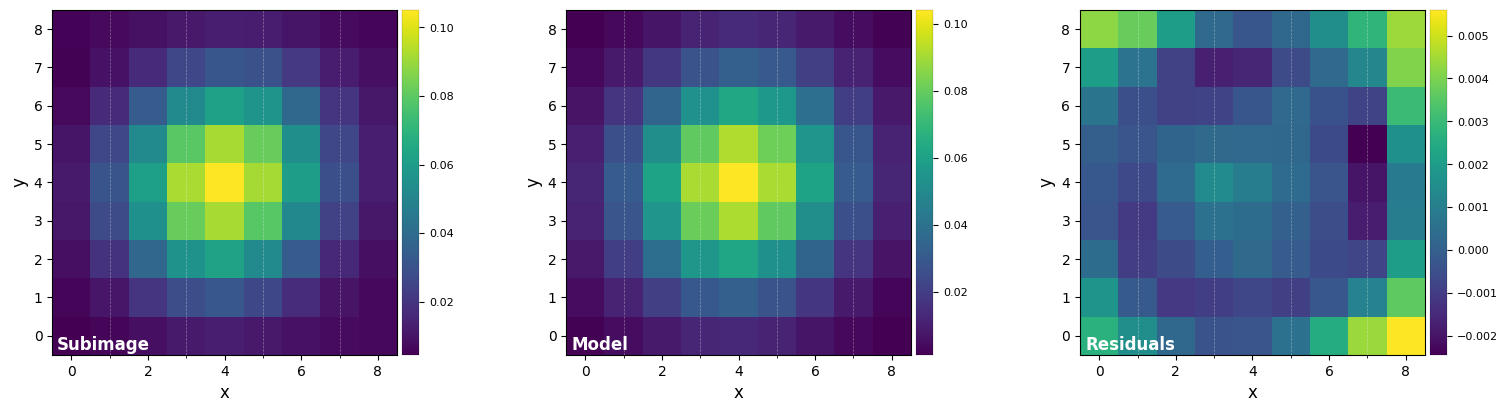

FWHM_y = 4.733218722257211
FWHM_x = 4.4736824050602895 

centroid y = 19.006680059041177
centroid x = 18.999424475165444
centroid y subim = 4.006680059041176
centroid x subim = 3.9994244751654446 

amplitude = 0.10413004853269539
theta = -34.08563676834199


In [4]:
%matplotlib inline
DF_fit = fit_2dgaussian(psf, crop=True, cropsize=9, debug=True, full_output=True)

In [5]:
fwhm_naco = np.mean([DF_fit['fwhm_x'],DF_fit['fwhm_y']])
print(fwhm_naco)

4.60345056365875


Let's normalize the flux to one in a 1xFWHM aperture and crop the PSF array:

In [6]:
psfn = normalize_psf(psf, fwhm_naco, size=19, imlib='ndimage-fourier')

Flux in 1xFWHM aperture: 1.228


Let's visualize the normalized PSF with `hciplot.plot_frames`. Feel free to adapt the `backend` argument throughout the notebook: `'matplotlib'` allows paper-quality figures with annotations which can be saved (default), while `'bokeh'` enables interactive visualization.

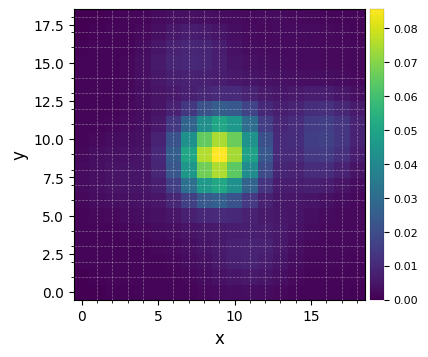

In [7]:
plot_frames(psfn, grid=True, size_factor=4)

Let's define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `config` subpackage:

In [8]:
pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


Now let's have a look at one single image of our toy datacube. We see that the dark hole is clearly off-center:

New shape: (15, 15)


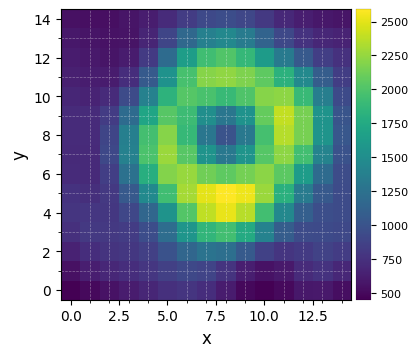

In [9]:
plot_frames(frame_crop(cube_orig[0], 15), grid=True, size_factor=4)

For this NACO+AGPM dataset, three approaches could be considered for recentering - all assuming that the average location of the star throughout the observation coincides with the sweet spot (dark hole) of the coronagraph: 

### 2.1.2. Recentering with individual 2D negative Gaussian fits

This approach consists in fitting a negative 2D Gaussian model to the dark hole area for each individual image. The coordinates of the centroid of the negative 2D Gaussian are then used to shift and align all images.

If using a different datacube, you may need to adjust the position `xy` of the center of the coronagraphic PSF to be fitted and the `subi_size` (sub-image size used for the fit, in pixels). Only use the `debug` mode on small datacubes (less than 20 frames), e.g. on a small subset of your datacube. In `debug` mode, set `nproc` to 1 or the plots won't show up (values larger than 1 trigger multiprocessing).

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:36:22
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2d gauss-fitting
frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.318358
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


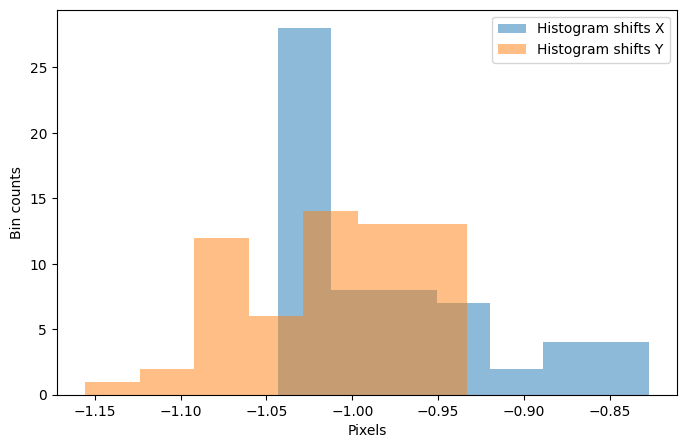

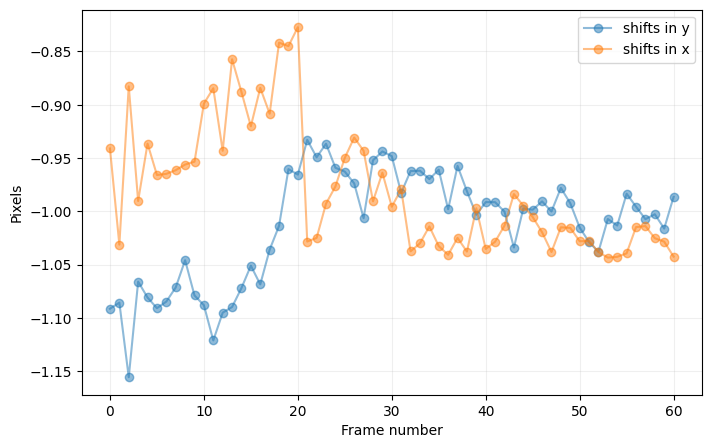

In [10]:
cube1, shy1, shx1 = cube_recenter_2dfit(cube_orig, xy=(51, 51), fwhm=fwhm_naco, nproc=1, subi_size=5, 
                                        model='gauss', negative=True, full_output=True, debug=False, 
                                        imlib='ndimage-fourier')

### 2.1.3. Recentering with cross-correlation + 2D negGaussian

This approach is a two-step procedure involving i) a cross-correlation based method in the Fourier plane used for alignment of the images with respect to each other and ii) fitting of a negative 2D gaussian to the mean of the aligned cube for final centering.

i) By not providing `subi_size` (default None), the routine will not try to recenter the first frame but simply align the subsequent frames with respect to the first one. If `subi_size` is an integer, it will be the size of the box used to fit a 2d gaussian to the first image, before aligning the subsequent frames to it (feel free to try running the cell below after uncommenting)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:36:23
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
The first frame is assumed to be well centered wrt thecenter of the array
The rest of the frames will be shifted by cross-correlation wrt the 1st
Running time:  0:00:00.500753
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Shifts required to align the frames of the cube with respect to the first one:


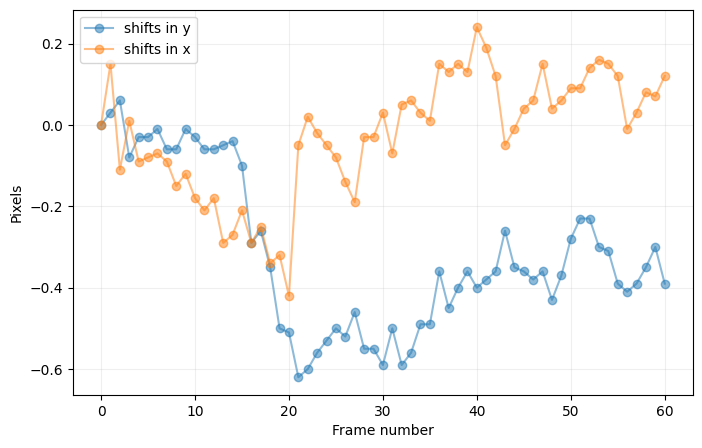

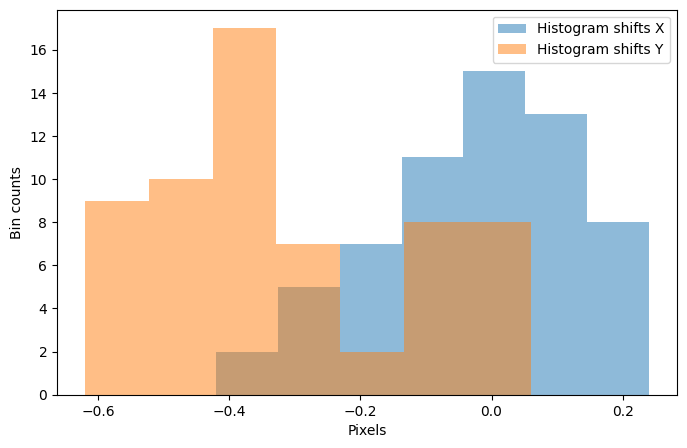

In [11]:
cube_align, shy2a, shx2a = cube_recenter_dft_upsampling(cube_orig, center_fr1=(51, 51), 
                                                        fwhm=fwhm_naco, #subi_size=5, negative=True,
                                                        full_output=True, debug=False, imlib='ndimage-fourier')
cube_al_mean = np.mean(cube_align,axis=0)
print("Shifts required to align the frames of the cube with respect to the first one:")
plt.show()

ii) we then leverage on the higher S/N in the mean image of all aligned images in order to find the final shift to place the star at the center of the images.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:36:24
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2d gauss-fitting
frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.010248
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Final shift to place the star at the center of the images:


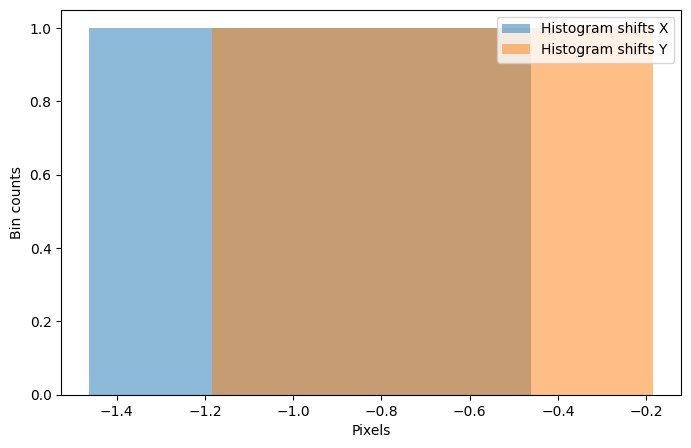

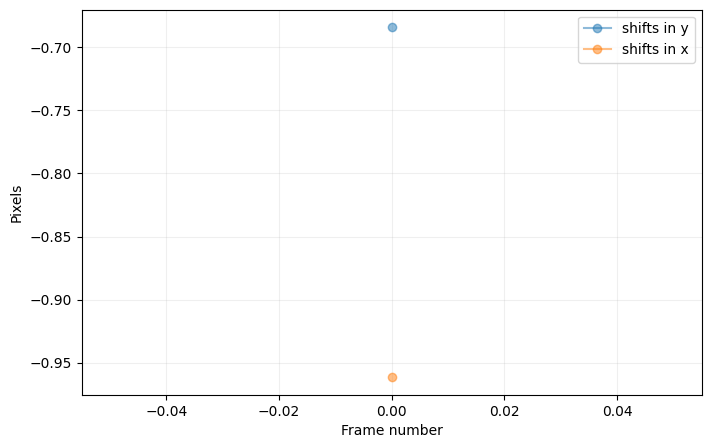

Combined shifts:


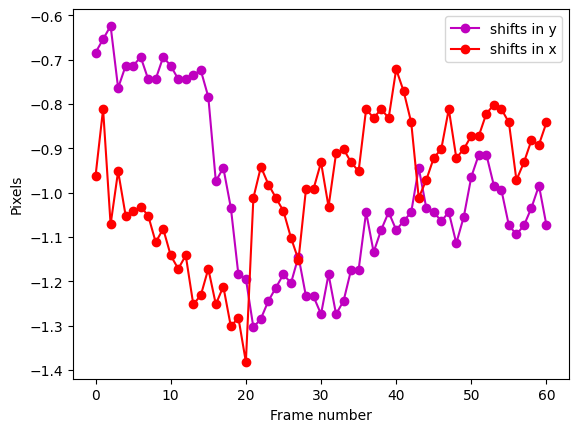

In [12]:
_, shy2b, shx2b = cube_recenter_2dfit(cube_al_mean[np.newaxis,:,:], xy=(51, 51), fwhm=fwhm_naco, 
                                      nproc=1, subi_size=5, model='gauss', negative=True, 
                                      full_output=True, debug=False, imlib='ndimage-fourier')
print("Final shift to place the star at the center of the images:")
plt.show()
cube2 = cube_shift(cube_align, shy2b[0], shx2b[0], imlib='ndimage-fourier')
shy2 = shy2a+shy2b[0]
shx2 = shx2a+shx2b[0]

print("Combined shifts:")
plt.plot(range(cube_orig.shape[0]),shy2,'mo-', label='shifts in y')
plt.plot(range(cube_orig.shape[0]),shx2,'ro-', label='shifts in x')
plt.xlabel("Frame number")
plt.ylabel("Pixels")
plt.legend()
plt.show()

### 2.1.4. Recentering with iterative speckle cross-correlation + 2D negGaussian

This approach is iterative and involves two steps at each iteration: i) the images of the cube are aligned with respect to each other based on cross-correlation of the speckles in log-scale intensity images (log scale to better capture fainter speckle with radial separation); ii) 2D negative Gaussian fit of the  median image of the aligned cube. By default, it involves 5 iterations. It is well suited for coronagraphic data where an extended speckle pattern can be seen in the images in log scale and where the imprint of the coronagraph can be represented by an inverted Gaussian (e.g. NIRC2+AGPM, NACO+AGPM or ERIS+AGPM).

Sub frame shape: (61, 49, 49)
Center pixel: (24, 24)
Square sum of shift vecs: 89.44960130532182
Square sum of shift vecs: 3.0493191038521013
Square sum of shift vecs: 1.0087524349940595
Square sum of shift vecs: 0.19414213562373095
Square sum of shift vecs: 0.07


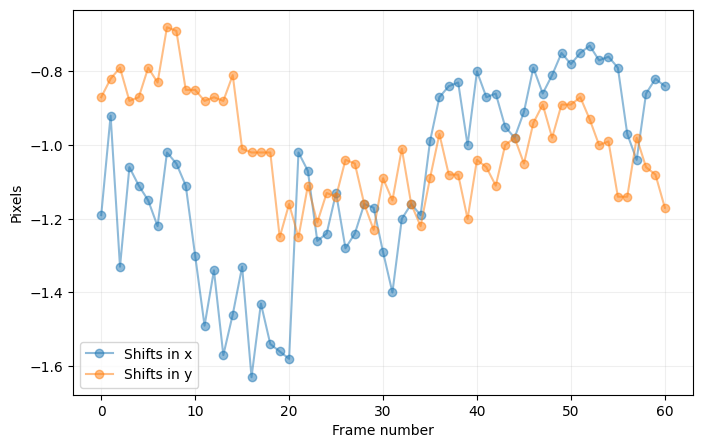

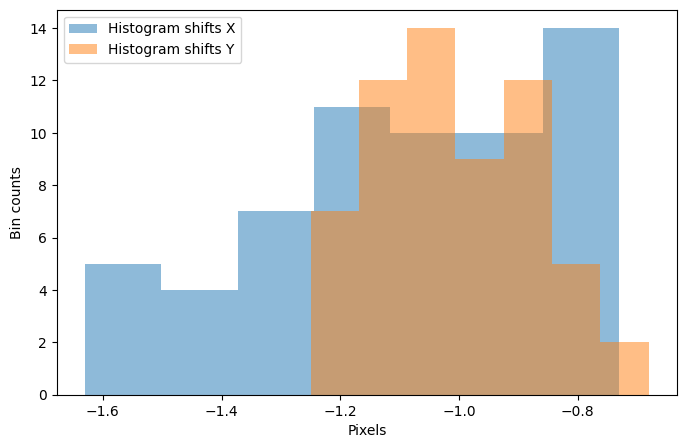

In [13]:
cube3, _, _, shy3, shx3 = cube_recenter_via_speckles(cube_orig, alignment_iter=5, fwhm=fwhm_naco, debug=False, 
                                                     recenter_median=True, fit_type='gaus', negative=True, 
                                                     crop=True, subframesize=49, mask=None, 
                                                     imlib='ndimage-fourier', plot=True, full_output=True)

### 2.1.5. Validation of the best recentering method

Frame re-centering is a case-dependent procedure. Since for this dataset there is a known companion, we can use it to infer the performance of each recentering method. All other pre-processing steps being identical, the S/N ratio of the companion is expected to be optimal with PCA-ADI (with 1 principal component used) for the cube with the best centering for the star. Not only is the companion expected to stack up in a more constructive way after derotation, but the modeling and subtraction of speckles may be slightly better if the images are perfectly aligned.

Let's post-process each cube with PCA (npc=1), and measure the S/N ratio of Beta Pic b:

In [14]:
fr1 = pca(cube1, angs)
fr2 = pca(cube2, angs)
fr3 = pca(cube3, angs)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:36:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 1.085 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.189475
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:01.386619
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:36:27
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 1.034 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.110408
―――――

Let's visualize the final images:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
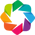

:Layout
   .Image.I   :Image   [x,y]   (z)
   .Image.II  :Image   [x,y]   (z)
   .Image.III :Image   [x,y]   (z)

In [15]:
plot_frames((fr1, fr2, fr3), backend='bokeh')

Let's write down the coordinates of the point source:

In [16]:
xy = (59., 35.4) # (35.8, 58.2)

Now let's measure the S/N ratio of the companion in each case - excluding the adjacent negative side lobes which can bias the estimate (more details in Tutorial `4. Metrics`):

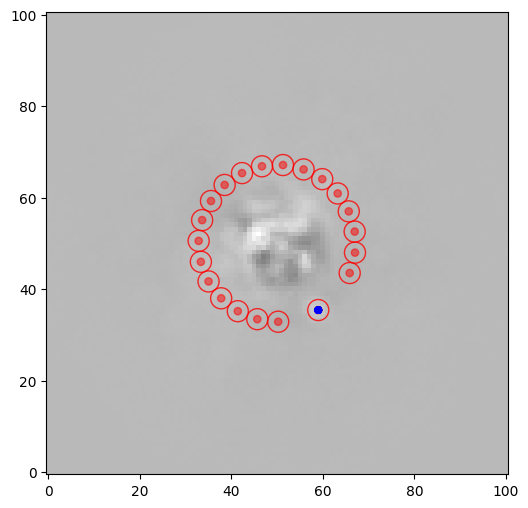

In [17]:
snr1 = snr(fr1, xy, fwhm_naco, exclude_negative_lobes=True, plot=True)
snr2 = snr(fr2, xy, fwhm_naco, exclude_negative_lobes=True, plot=False)
snr3 = snr(fr3, xy, fwhm_naco, exclude_negative_lobes=True, plot=False)

In [18]:
print(snr1, snr2, snr3)

3.095026512234757 3.540201701280137 3.6364819400155795


The third method appears to lead to a slightly better S/N ratio for Beta Pic b (all other pre- and post-processing steps being the same), although it is fair to mention that all of them yield S/N values in the same ballpark. 

Based on our experience with different AGPM datasets, the iterative speckle-correlation based alignment + negative 2D Gaussian fit method is the one we recommend to use to recenter AGPM data.

In [19]:
cube_cen = cube3

### 2.1.6. Bad frame trimming

ADI-based post-processing algorithms rely on *angular diversity* to produce a PSF model and subtract it from each image of the datacube: a putative planet rotates in the image while the stellar PSF is expected to be *mostly* static. The more stable the PSF in the image sequence, the better post-processing algorithms can leverage this (since it will be easier). For observations in highly stable conditions, a simple median image of the cube may be a good enough PSF model for subtraction.

Considering the above, an optimal reduction+post-processing pipeline should involve trimming bad frames. In VIP, several functions have been implemented to tackle this task:

- `cube_detect_badfr_ellipticity` to reject bad frames based on the ellipticity of the PSF;
- `cube_detect_badfr_pxstats` to reject bad frames based on pixel intensity statistics in a given area of the image;
- `cube_detect_badfr_correlation` to reject bad frames based on some measure of the cross-correlation or distance to a good frame.

By default, we recommend using the *cross-correlation* (or *distance*) criterion, in particular for algorithms involving a low-rank approximation of the image cube. Let's try it out on our Beta Pic dataset, and see how trimming bad frames can affect the S/N ratio of the companion.

One can use the median image of the sequence as reference:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:36:31
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 31 out of 61 (50.8%)
Running time:  0:00:00.170542
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


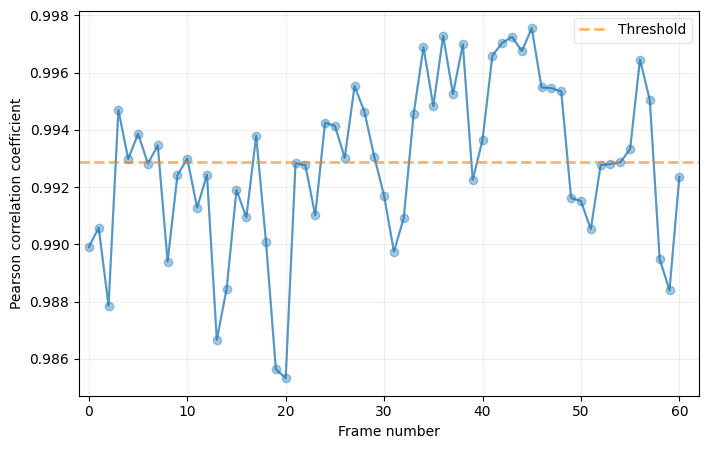

In [20]:
good_idx_f, bad_idx_f = cube_detect_badfr_correlation(cube_cen, frame_ref=np.median(cube_cen,axis=0), 
                                                      crop_size=31, dist='pearson', percentile=50, 
                                                      threshold=None, plot=True, verbose=True)

By default a (centered) cropped image is used for the calculation (set by `crop_sz`) of the Pearson correlation coefficient (PCC; `dist='pearson'`; although other metrics can be used). In practice, what is within 1 resolution element or hidden by a coronagraphic mask is usually not relevant, so it can be preferable to use an annular region for the calculation, set by `mode='annulus'`, `inradius` and `width`.

The bad frame rejection can be based either on a requested percentile (e.g. `percentile=30` means only the 70% most correlated frames are kept) or absolute threshold (if both are provided, `threshold` takes precedence).

Let's try an absolute threshold of 0.99 in an annular region encompassing the planet:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:36:31
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 29 out of 61 (47.5%)
Running time:  0:00:00.057203
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


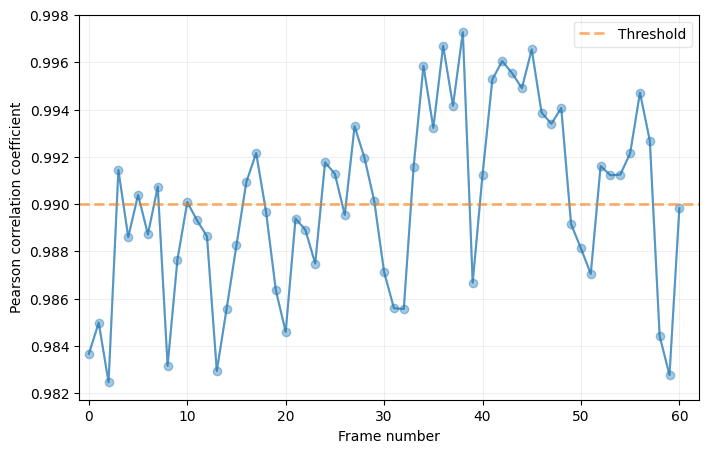

In [21]:
good_idx_a, bad_idx_a = cube_detect_badfr_correlation(cube_cen, frame_ref=np.median(cube_cen,axis=0), 
                                                      crop_size=31, dist='pearson', threshold=0.99, 
                                                      mode='annulus', inradius=int(fwhm_naco), 
                                                      width=int(4*fwhm_naco), plot=True, verbose=True)

Now let's compare the S/N ratio of the planet obtained after PCA-ADI post-processing on: the non-trimmed cube, the cube trimmed using the PCC in the cropped sub-image, and trimmed using the PCC in an annular region:

Don't forget to trim the associated parallactic angle vector as well:

In [22]:
cube_trim_f = cube_cen[good_idx_f]
angs_trim_f = angs[good_idx_f]

cube_trim_a = cube_cen[good_idx_a]
angs_trim_a = angs[good_idx_a]

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:36:31
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 1.045 GB
Done vectorizing the frames. Matrix shape: (30, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.088523
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:00.689348
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:36:32
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 1.048 GB
Done vectorizing the frames. Matrix shape: (32, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.046805
―――――

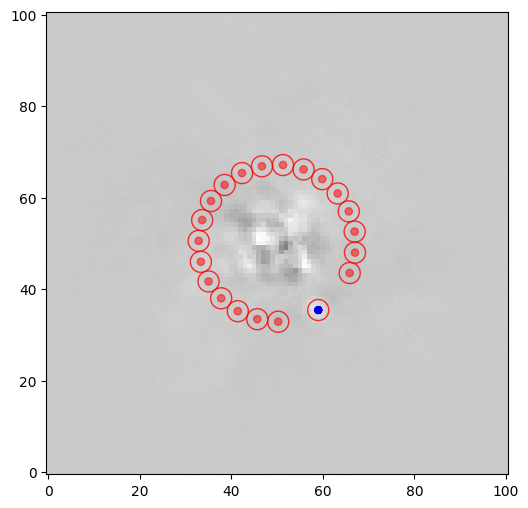

In [23]:
fr_trim_f = pca(cube_trim_f, angs_trim_f)
snr_trim_f = snr(fr_trim_f, xy, fwhm_naco, exclude_negative_lobes=True, plot=False)

fr_trim_a = pca(cube_trim_a, angs_trim_a)
snr_trim_a = snr(fr_trim_a, xy, fwhm_naco, exclude_negative_lobes=True, plot=True)

The measured S/N ratio in each of the 3 cases is:

In [24]:
print(snr3, snr_trim_f, snr_trim_a)

3.6364819400155795 3.901292346004648 4.908796692945628


We see that appropriate bad frame trimming can indeed boost the S/N ratio of a given companion.

Feel free to test other distance metrics.

## 2.2. Recentering coronagraphic SPHERE/IFS data

### 2.2.1. Loading the data

In the 'datasets' folder of the `VIP_extras` repository you can find a SPHERE/IFS 'CENTER' cube obtained on PDS 70 on February 24th, 2018. This datacube contains 4 satellite spots (located along a 'X') which can be used to infer the 
location of the star behind the coronagraph (at the intersection of the diagonals). A non-coronagraphic PSF spectral cube is also available.

The point of this section is to show how to:

- correct for residual bad pixels and NaN values;
- perform a fine centering of the images based on satellite-spots (in the presence of a contaminating background star);
- perform a fine centering based on the Radon transform. 

In [25]:
cubename = '../datasets/sphere_ifs_PDS70_cen.fits'
psfname = '../datasets/sphere_ifs_PDS70_psf.fits'
lbdaname = '../datasets/sphere_ifs_PDS70_wl.fits'
cube = open_fits(cubename)
psfifs = open_fits(psfname)
lbda = open_fits(lbdaname)

Fits HDU-0 data successfully loaded, header available. Data shape: (39, 199, 199)
Fits HDU-0 data successfully loaded, header available. Data shape: (39, 31, 31)
Fits HDU-0 data successfully loaded, header available. Data shape: (39,)


Each IFS spectral cube consists of 39 monochromatic images spread in wavelengths between the Y and J bands ('YJ' mode) or Y and H bands ('YJH' mode). 

A few 'CENTER' cubes are usually acquired for a given object of interest, either at the very beginning and very end of the observation, or at regular intervals throughout the observation, while the rest of the spectral cubes are usually obtained without satellite spots. The star location is typically inferred in those cubes by linear interpolation of the positions derived in the 'CENTER' cubes.

Given the large size of typical full IFS observations, in this tutorial we only include one 'CENTER' cube, and hence only showcase the actual determination of stellar positions in that specific cube (i.e. no linear interpolation to infer the stellar position in the rest of the observation).

Let's first visualize a few images from the CENTER spectral cube:

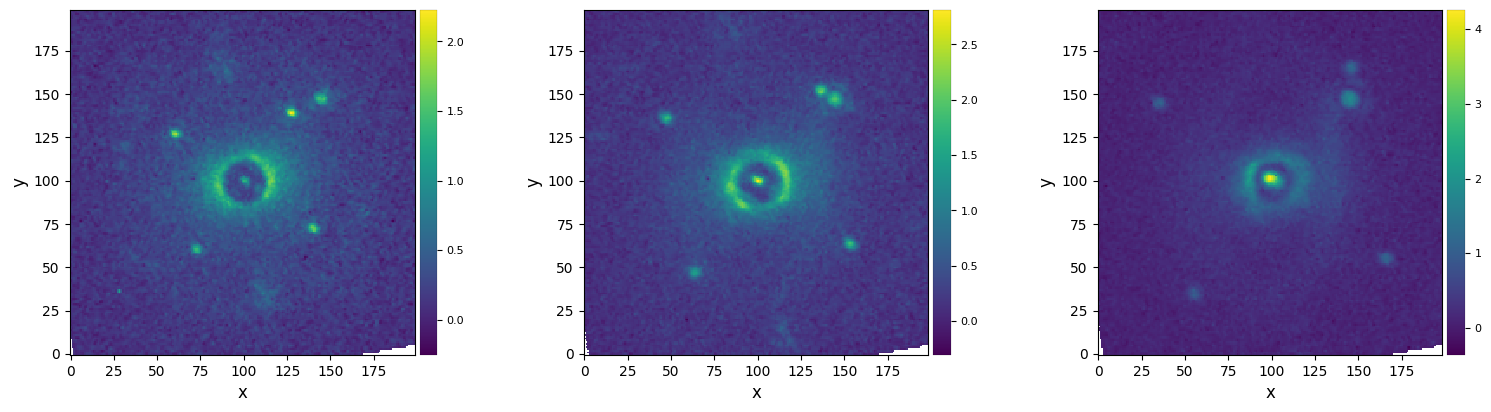

In [26]:
plot_frames((cube[1], cube[19], cube[-1]))

A couple of things can be noted from the inspection of the images:

- the 4 satellite spots are located along a 'x' shape, and expand radially with increasing wavelength;
- a bright background star (not moving radially) is present towards the top right - its close proximity to the top-right satellite spot may interfere with an accurate retrieval of the stellar position;
- a couple of hot/cold/bad pixels remain in the image (e.g. towards the bottom left of the first frame) - these are best seen when opening the images in a FITS viewer;
- there are NaN values in the bottom right corner.

We will therefore proceed with:

1. replacing NaN values;
2. correcting bad pixels;
3. removing a model of the background star;
4. recenter the cube based on the location of the satellite spots (we will see 2 different methods).

### 2.2.2. Replacing NaN values

Some FFT-based image operations in VIP (namely sub-px shifts) do not support NaN values (interpolation-based methods are fine). Let's replace the few NaN values at the bottom right corner of the images right away to avoid any bug during the recentering of the images.

In [27]:
cube_nancorr = cube_correct_nan(cube, neighbor_box=5, min_neighbors=5)

The `cube_correct_nan` function replace NaN values by the median of good neighbours, iteratively until all NaN values are corrected. One can increase the box size `neighbor_box`  (less iterations) or reduce the minimum number of good neighbours `min_neighbors` for a faster correction of large chunks of NaN values (consider cropping if located at the edges).

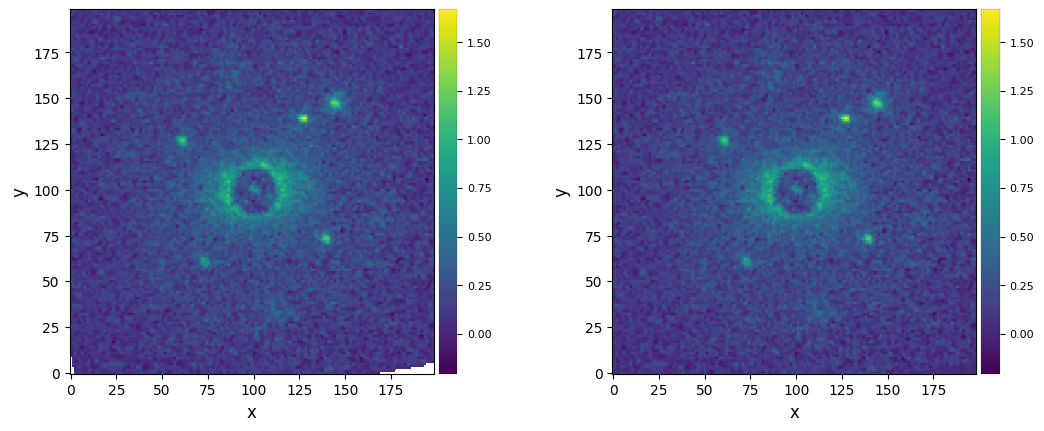

In [28]:
plot_frames((cube[0], cube_nancorr[0]))

Now let's remove the background star for a good 2D fit of all satellite spots.
Note: background star overlapping with a satellite spot is an uncommon issue, feel free to skip directly to [Sec. 2.2.5](#2.2.5.-Satellite-spot-based-recentering) if you do not have to deal with this issue, or are only interested in the recentering part.

### 2.2.3. Bad pixel correction

Several bad pixel correction algorithms are available in VIP:
1. `cube_fix_badpix_isolated`: to correct isolated bad pixels by sigma filtering;
2. `cube_fix_badpix_annuli`: which identifies bad pixels in concentric annuli (requires a circularly symmetric PSF), and replace them with the median of the value in the annulus (+ a random value following Poisson distribution);
3. `cube_fix_badpix_clump`: which iteratively identifies bad pixels by sigma filtering, and replace them with the median of good neighour pixels (useful for clumps of bad pixels);
4. `cube_fix_badpix_ifs`: which leverages the radial expanion of the PSF with wavelength in IFS cubes to better identify bad pixels;
5. `cube_fix_badpix_with_kernel`: which corrects bad pixels using a 2D Gaussian kernel (requires an input bad pixel map, possibly found by one of the first 4 methods).

#### 2.2.3.1. Sigma filter

Given that the bad pixels seem to be relatively isolated in the IFS images, let's simply use the first approach (the fastest) in 2 steps. First we correct for static bad pixels, by only looking for bad pixels in the mean image of the cube (`frame_by_frame=False`):

In [29]:
cube_sigcorr, bpm_mask = cube_fix_badpix_isolated(cube_nancorr, sigma_clip=5, num_neig=9, size=9, 
                                                  frame_by_frame=False, mad=True, verbose=True, 
                                                  full_output=True) 

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:36:34
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
processing frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
Done replacing 2418 bad pixels using the median of neighbors
(i.e. 62 static bad pixels per channel))
Running time:  0:00:08.427947
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Next we also catch individual bad pixels (e.g. due to cosmic rays):

In [30]:
cube_sigcorr, bpm_mask_tmp = cube_fix_badpix_isolated(cube_sigcorr, sigma_clip=5, num_neig=9, size=9, 
                                                      frame_by_frame=True, mad=True, 
                                                      verbose=True, full_output=True)
bpm_mask_2d = bpm_mask
bpm_mask = np.zeros_like(cube_nancorr)
for i in range(cube_nancorr.shape[0]):
    bpm_mask[i] = bpm_mask_2d+bpm_mask_tmp[i]

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:36:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
processing frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:27
Done replacing 91 bad pixels using the median of neighbors
Running time:  0:02:27.559500
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Feel free to adapt the sigma clipping threshold `sigma_clip`, box size for outlier identification and median filtering (through `num_neig` and `size`, respectively), and test using standard deviations instead of median absolute deviations for outlier identification (`mad=False`). 

Let's visualize both the static and total individual bad pixel masks (i.e. summed over all spectral channels):

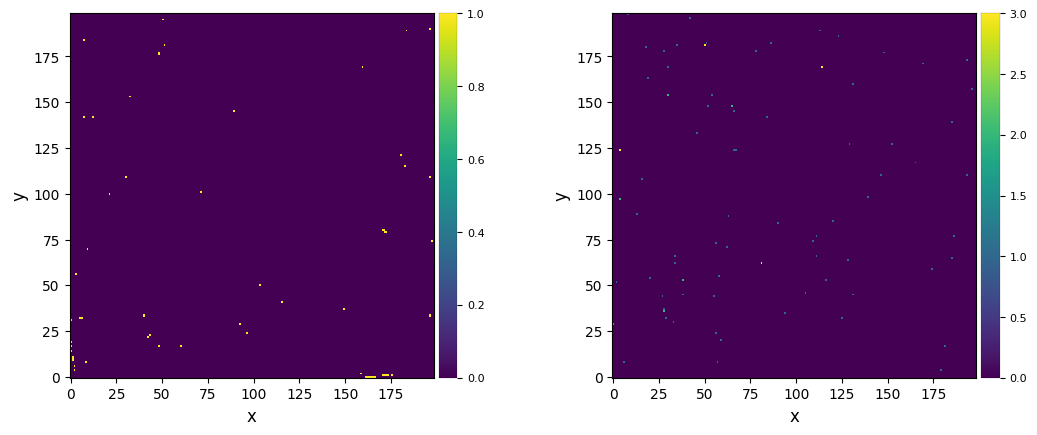

In [31]:
plot_frames((bpm_mask_2d, np.sum(bpm_mask_tmp,axis=0)))

Let's now check one frame of the cube before and after bad pixel correction, and the difference between them:

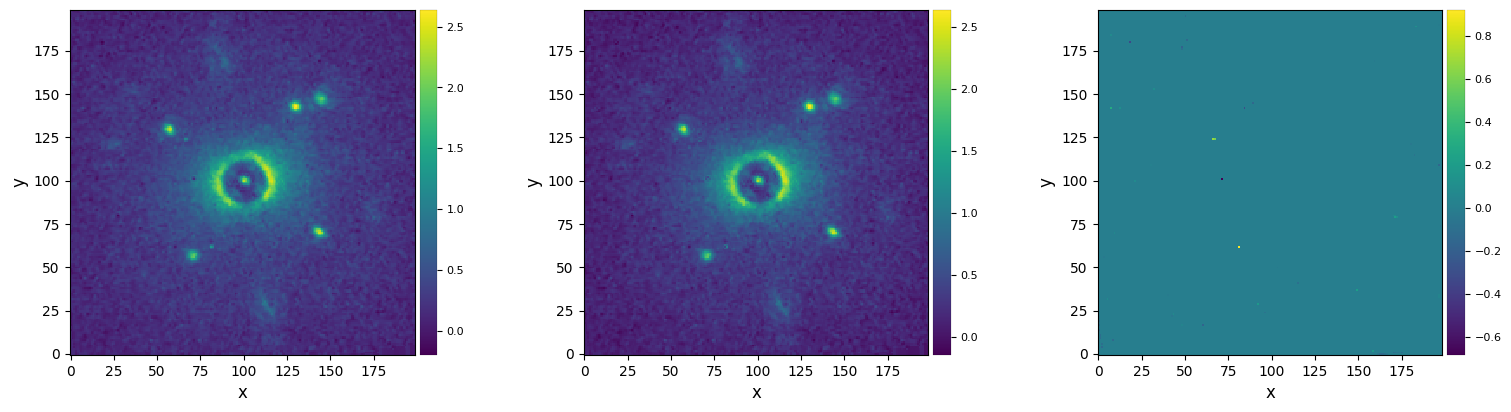

In [32]:
test_idx = 6
plot_frames((cube_nancorr[test_idx], cube_sigcorr[test_idx], cube_nancorr[test_idx]-cube_sigcorr[test_idx]))

Note that `numba` can significantly increase the speed of the bad pixel correction (`numba` is not a mandatory dependency of VIP, so you have to install it separately).

#### 2.2.3.2. DFT-extrapolation

Another approach, provided a map of bad pixels, is to correct them with an iterative spectral deconvolution algorithm [(Aach & Metzler 2001)](https://ui.adsabs.harvard.edu/abs/2001SPIE.4322..824A/abstract). The observed image with bad pixels can be written as g(x,y) = f(x,y) * w(x,y), where f(x,y) is the original image as it would be seen in absence of bad pixel, and w(x,y) a binary bad pixel mask. The spectral deconvolution method relies on:
- the fact that the FT of a product of 2 functions is equal to the convolution of their respective FT;
- the  estimation of F(u,v), the FT of f(x,y), by iteratively including the most significant spectral lines from G_i(u,v), where G_i(u,v) is set to G(u,v) at the first iteration, and is then removed from its most significant mode at each subsequent iteration.

This algorithm is available in VIP (v1.3.1 onwards) in `frame_fix_badpix_fft` for 2D images. For 3D cubes, one can use `cube_fix_badpix_interp` with `mode='fft'`. The latter also contains the option to perform a (much faster) correction using a Gaussian kernel interpolation (illustrated in Sec. [2.3.3](#2.3.3.-Bad-pixel-correction)).
Let's consider the first 10 frames of the cube, for correction:

In [33]:
if version.parse(vvip) >= version.parse("1.3.1"):
    test_idx = np.arange(9)
    cube_fftcorr = cube_fix_badpix_interp(cube_nancorr[test_idx], bpm_mask[test_idx], mode='fft', nit=100, nproc=None)

Correcting bad pixels with 5 processes
iterative bad pixel correction
iterative bad pixel correction
iterative bad pixel correction
iterative bad pixel correction
iterative bad pixel correction
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:28
iterative bad pixel correction
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:28
iterative bad pixel correction
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:28
iterative bad pixel correction
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:28
iterative bad pixel correction
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:28
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:28
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:28
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:

Let's compare the correction obtained with the spectral deconvolution algorithm to sigma-filtering, in two regions of interest:

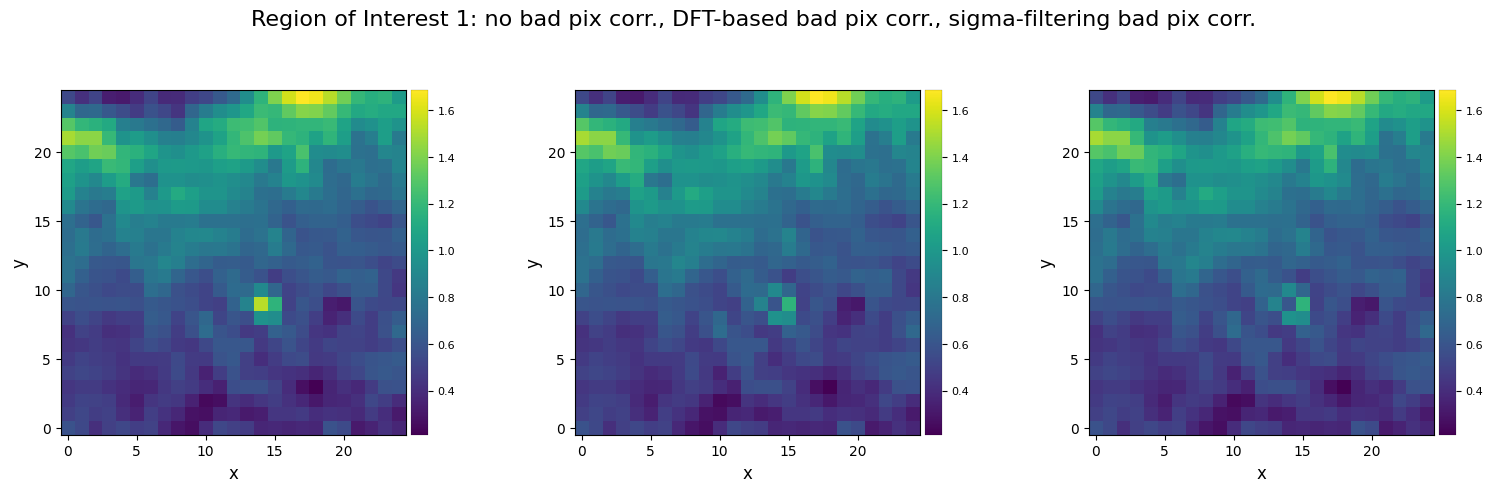

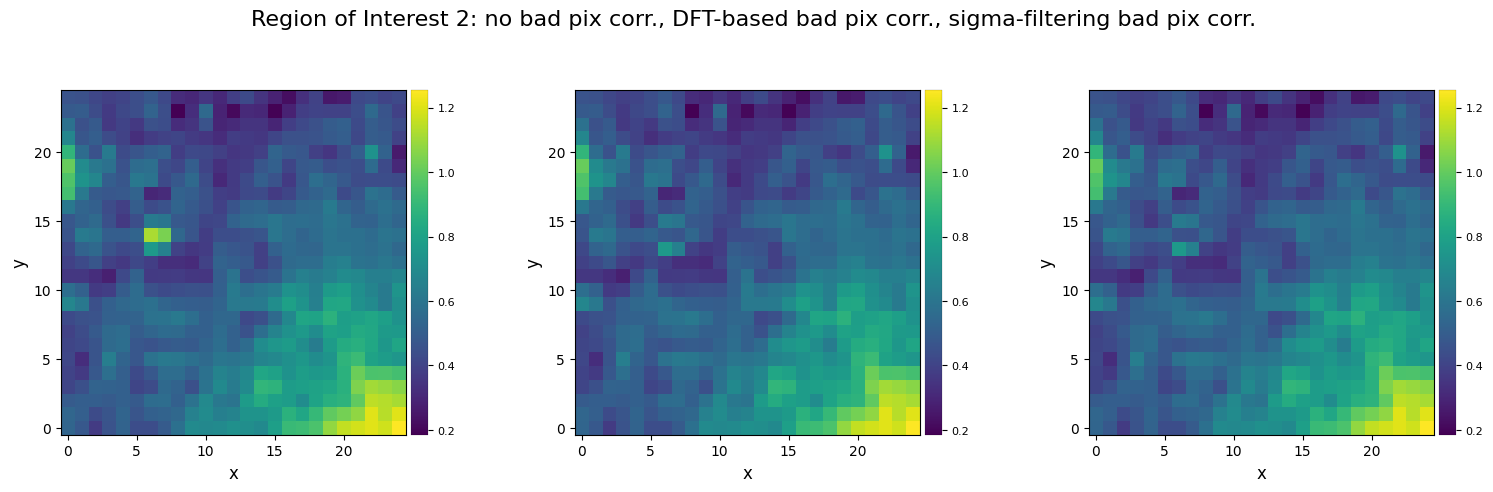

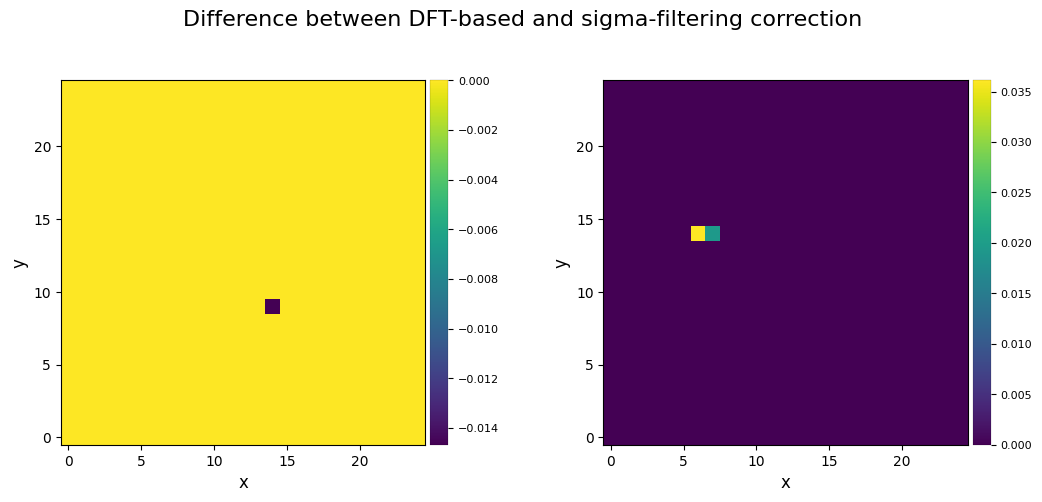

In [34]:
if version.parse(vvip) >= version.parse("1.3.1"):
    idx1 = 3
    roi_y0, roi_y1 = 65, 90
    roi_x0, roi_x1 = 95, 120
    idx2 = 6
    roi_y02, roi_y12 = 110, 135
    roi_x02, roi_x12 = 60, 85
    plot_frames((cube_nancorr[idx1,roi_y0:roi_y1,roi_x0:roi_x1], 
                 cube_fftcorr[idx1,roi_y0:roi_y1,roi_x0:roi_x1], 
                 cube_sigcorr[idx1,roi_y0:roi_y1,roi_x0:roi_x1]), 
                title="Region of Interest 1: no bad pix corr., DFT-based bad pix corr., sigma-filtering bad pix corr.")
    plot_frames((cube_nancorr[idx2,roi_y02:roi_y12,roi_x02:roi_x12], 
                 cube_fftcorr[idx2,roi_y02:roi_y12,roi_x02:roi_x12], 
                 cube_sigcorr[idx2,roi_y02:roi_y12,roi_x02:roi_x12]),
                title="Region of Interest 2: no bad pix corr., DFT-based bad pix corr., sigma-filtering bad pix corr.")
    # difference
    plot_frames((cube_fftcorr[idx1,roi_y0:roi_y1,roi_x0:roi_x1]-cube_sigcorr[idx1,roi_y0:roi_y1,roi_x0:roi_x1],
                 cube_fftcorr[idx2,roi_y02:roi_y12,roi_x02:roi_x12]-cube_sigcorr[idx2,roi_y02:roi_y12,roi_x02:roi_x12]),
                title="Difference between DFT-based and sigma-filtering correction")

The correction is very similar in this case. Albeit slower, the spectral deconvolution algorithm can perform better for large clumps of bad pixels. Let's illustrate that below, by artificially masking a large block of pixels, and compare the results obtained with sigma filtering and DFT-extrapolation to the original pixel intensities:

In [35]:
if version.parse(vvip) >= version.parse("1.3.1"):
    test_idx = 1
    ty0, ty1 = 25, 29
    tx0, tx1 = 159, 165
    bpm_mask_test = bpm_mask.copy()
    bpm_mask_test[test_idx,ty0:ty1, tx0:tx1] = 1  # set them as bad pixels even if good

In [36]:
if version.parse(vvip) >= version.parse("1.3.1"):
    frame_fftcorr = cube_fix_badpix_interp(cube_nancorr[test_idx], bpm_mask_test[test_idx], tol=10, nit=2000)
    frame_sigcorr = frame_fix_badpix_isolated(cube_nancorr[test_idx], bpm_mask_test[test_idx],
                                          sigma_clip=5, num_neig=9, size=9, mad=True, 
                                          verbose=True, full_output=False)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:40:10
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
iterative bad pixel correction
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:09:19
FFT-interpolation terminated after 2000 iterations (Eg=125.06167102229024)
Running time:  0:09:19.640611
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:49:29
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done replacing 257 bad pixels using the median of neighbors
Running time:  0:00:06.813054
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


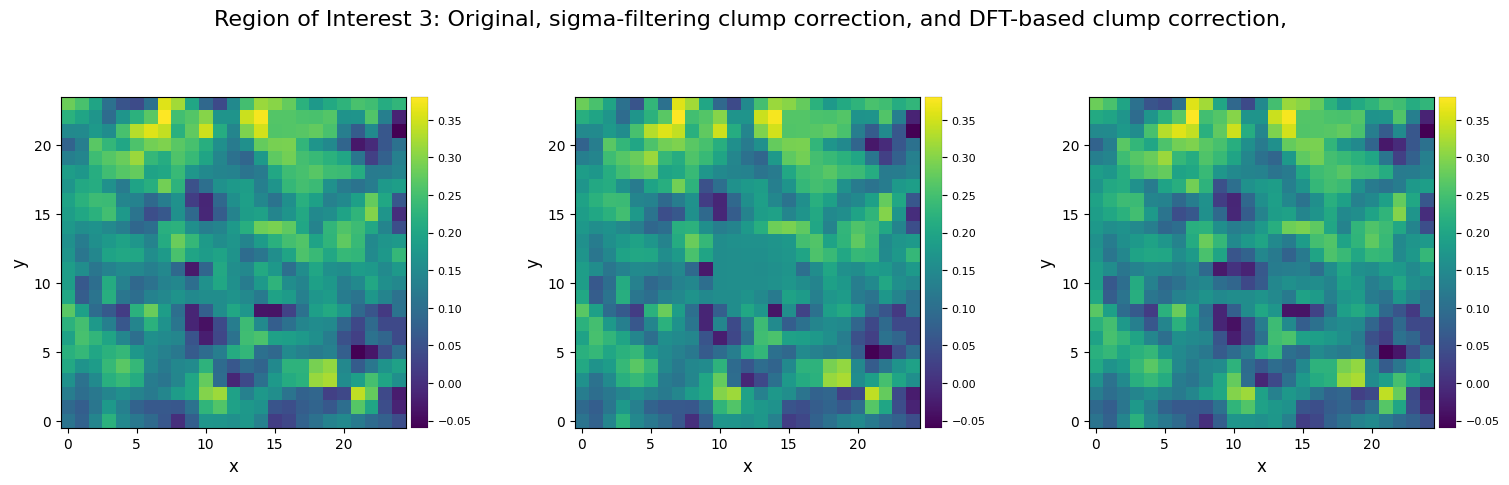

In [37]:
if version.parse(vvip) >= version.parse("1.3.1"):
    roi_y0, roi_y1 = ty0 - 10, ty1 + 10
    roi_x0, roi_x1 = tx0 - 10, tx1 + 9

    plot_frames((cube_nancorr[test_idx,roi_y0:roi_y1,roi_x0:roi_x1],
                 frame_sigcorr[roi_y0:roi_y1,roi_x0:roi_x1],
                 frame_fftcorr[roi_y0:roi_y1,roi_x0:roi_x1]), 
                title="Region of Interest 3: Original, sigma-filtering clump correction, and DFT-based clump correction, ")


Note that `cube_fix_badpix_ifs` would have been another option to correct for bad pixels in this IFS dataset, provided that the images are first aligned with respect to each other.

### 2.2.4. Background-star removal

In [38]:
cube_corr = cube_sigcorr

We'll use the non-coronagraphic PSF observed during the same night to subtract the background star. Let's first normalize the observed non-coronagraphic PSF to an integrated flux of 1 within 1 FWHM. By default the FWHM is found by fitting a 2D Gaussian model with the `normalize_psf` function:

In [39]:
crop_sz = 15
norm_psf, flux, fwhm = normalize_psf(psfifs, fwhm='fit', full_output=True, size=crop_sz)

Mean FWHM per channel: 
[5.2   5.227 5.23  5.245 5.287 5.327 5.357 5.378 5.398 5.418 5.481 5.552
 5.599 5.627 5.657 5.689 5.73  5.787 5.828 5.85  5.868 5.857 5.804 6.105
 6.362 6.23  6.225 6.255 6.3   6.349 6.39  6.423 6.444 6.491 6.539 6.592
 6.659 6.727 6.787]
Flux in 1xFWHM aperture: 
[ 4999.616  8605.83  10904.33  12126.272 13194.393 14388.846 15444.562
 15987.688 14864.771 12628.708 12302.344 14227.798 16315.584 17630.115
 18578.563 19438.338 20021.445 20474.703 20939.023 20619.506 18458.71
 13514.223  7473.132  3730.324  3097.108  4777.345  7698.074 10945.942
 14079.887 17093.565 20077.491 22889.499 25092.631 26571.491 27175.983
 27369.823 27411.929 27244.554 26593.662]


Now let's measure the approximate position of the BKG star in the median image of the spectral cube:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
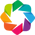

:Layout
   .Image.I :Image   [x,y]   (z)

In [40]:
median_fr = np.nanmedian(cube_corr, axis=0)
plot_frames(median_fr, backend='bokeh')

The approximate position is:

In [41]:
bkg_xy = (144, 147)

To refine the position of the background star, let's fit a 2D Gaussian to the median frame (the `debug` option enables to check the residuals after model subtraction):

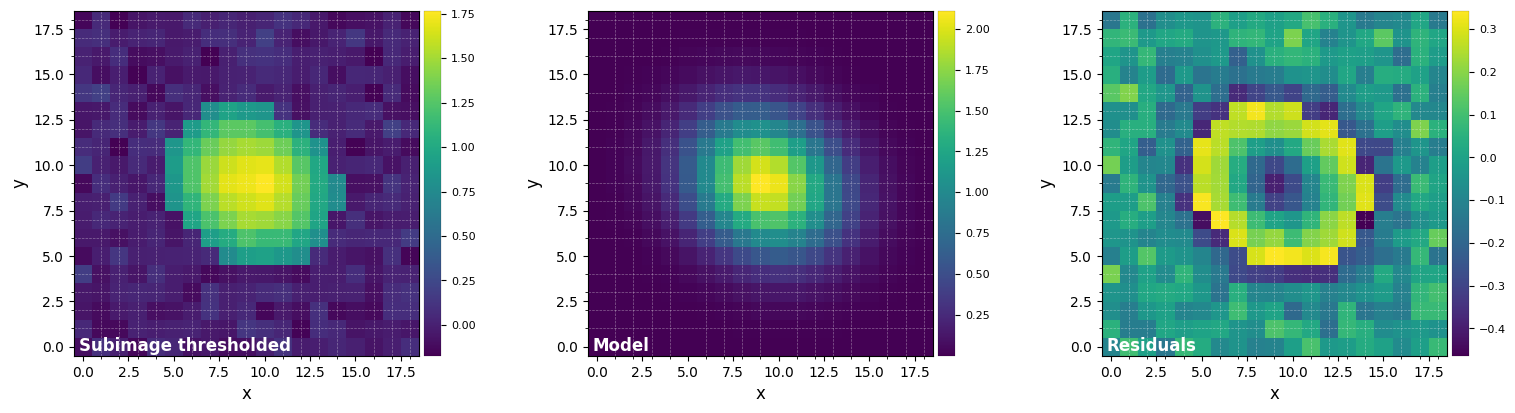

FWHM_y = 5.669732327308855
FWHM_x = 6.699616809140478 

centroid y = 147.0249831162251
centroid x = 144.28362101625402
centroid y subim = 9.024983116225089
centroid x subim = 9.283621016254017 

amplitude = 2.1224488247925684
theta = -213.57798949909397


In [42]:
med_y, med_x = fit_2dgaussian(median_fr, crop=True, cent=bkg_xy, cropsize=19, threshold=True, 
                              sigfactor=4, full_output=False, debug=True)

Let's also try to fit a 2D Gaussian to the individual spectral frames - now using the `full_output` option to retrieve all parameters of the fit:

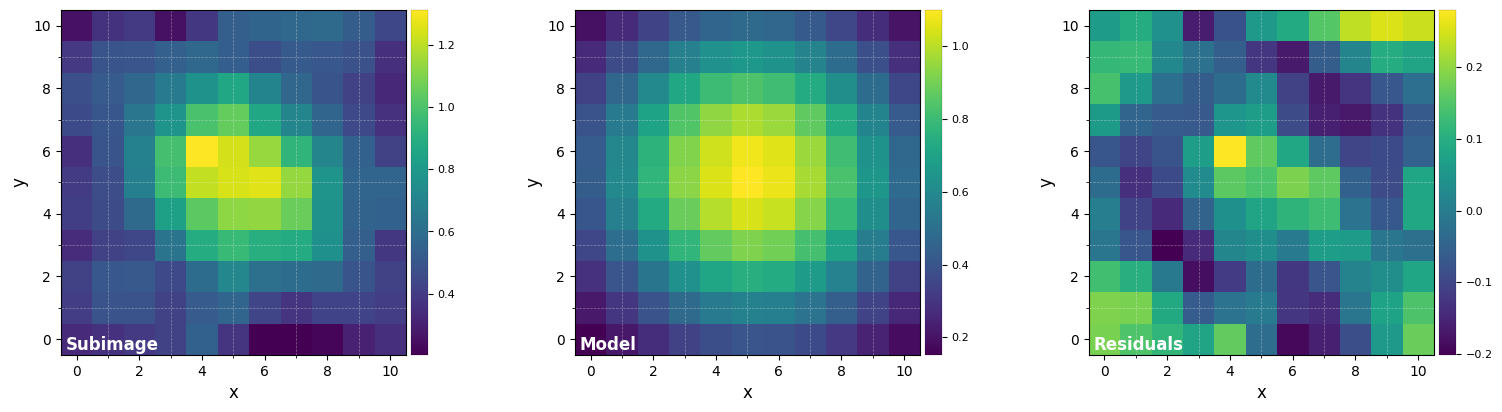

FWHM_y = 8.660307473401705
FWHM_x = 8.92478275024527 

centroid y = 147.23911854827043
centroid x = 144.1526625208313
centroid y subim = 5.239118548270438
centroid x subim = 5.152662520831313 

amplitude = 1.1032486182399754
theta = -23.162856641608624


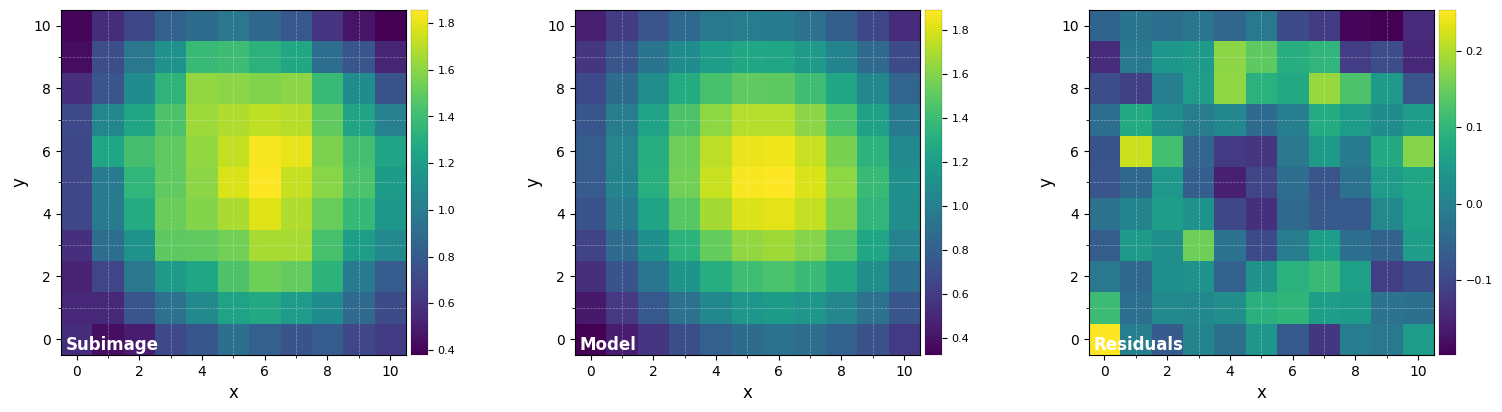

FWHM_y = 9.544127081132364
FWHM_x = 10.373896190867667 

centroid y = 147.15558384643563
centroid x = 144.6347396144857
centroid y subim = 5.155583846435644
centroid x subim = 5.6347396144857145 

amplitude = 1.901320547133558
theta = 313.7354704176627


In [43]:
fit_xy = np.zeros([cube.shape[0], 2])
fit_fwhm = np.zeros([cube.shape[0], 2])
fit_amp = np.zeros([cube.shape[0]])
fit_theta = np.zeros([cube.shape[0]])
for z in range(cube.shape[0]):
    if z == 0 or z == cube.shape[0]-1:
        # to avoid too many plots, let's just check the residuals for the first and last spectral frame
        debug = True
    else:
        debug = False
    res = fit_2dgaussian(cube_corr[z], crop=True, cent=(med_x, med_y), cropsize=11,
                         threshold=False, sigfactor=0.5, full_output=True, debug=debug)
    fit_xy[z,0] = float(res['centroid_x'].iloc[0])
    fit_xy[z,1] = float(res['centroid_y'].iloc[0])
    fit_fwhm[z,0] = float(res['fwhm_x'].iloc[0])
    fit_fwhm[z,1] = float(res['fwhm_y'].iloc[0])
    fit_amp[z] = float(res['amplitude'].iloc[0])
    fit_theta[z] = float(res['theta'].iloc[0])

Let's plot the x,y positions found by the fits:

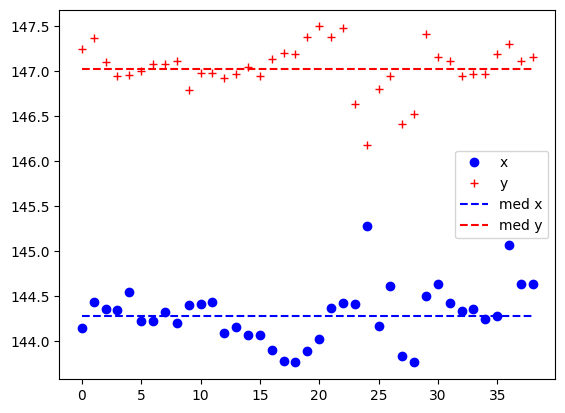

In [44]:
cols = ['b', 'r']
marks = ['o', '+']
plt.plot(range(cube.shape[0]), fit_xy[:,0], cols[0]+marks[0], label = 'x')
plt.plot(range(cube.shape[0]), fit_xy[:,1], cols[1]+marks[1], label = 'y')
plt.plot(range(cube.shape[0]), [med_x]*cube.shape[0], cols[0]+'--', label = 'med x')
plt.plot(range(cube.shape[0]), [med_y]*cube.shape[0], cols[1]+'--', label = 'med y')
plt.legend()

Although the residual images do not show any obvious bias by the nearby satellite spot this time, the estimated position changes by up to ~1-2 px. It is unclear whether this is due to noisy data or actual jittering. 

Let's use the `normalize_psf` function again, this time to measure the flux in each spectral channel at the location of the BKG star. Before that we provide a sub-cube, centered at the median location of the BKG star. Internally, a step of recentering is performed (with 2D Gaussian fits similar to above) before measuring the flux in 1-FWHM radius apertures. Note that this time we fixed the value of `fwhm` in each spectral channels to the values found previously with the non-coronagraphic PSF:

In [45]:
subcube = cube_crop_frames(cube, size=13, xy=(med_x, med_y))
res = normalize_psf(subcube, fwhm=fwhm, threshold=None, full_output=True, verbose=True, debug=True)
fit_flux = res[1]

New shape: (39, 13, 13)
Flux in 1xFWHM aperture: 
[22.274 27.988 30.231 32.978 33.926 35.492 36.131 35.786 33.806 32.51
 33.515 35.477 38.082 40.757 39.925 40.084 42.377 43.566 43.317 43.937
 43.55  38.84  30.284 26.018 27.192 30.244 34.278 39.913 43.786 46.135
 48.691 49.838 51.637 53.332 54.734 55.714 56.277 56.607 57.52 ]


Let's plot the flux inferred for the BKG star:

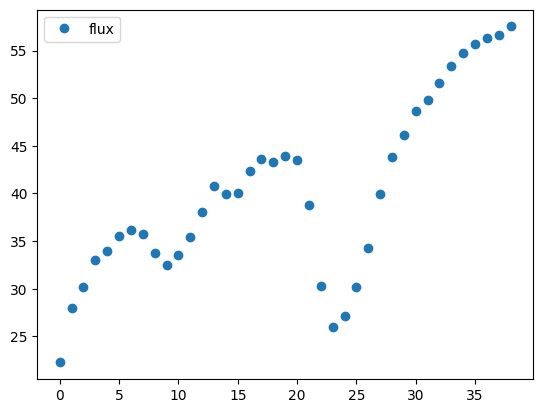

In [46]:
cols = ['b', 'r']
marks = ['o', 'D']
plt.plot(range(cube.shape[0]), fit_flux[:], marks[0], label = 'flux')
plt.legend()

Now let's use this flux to scale the normalized PSF and subtract it to each frame of the cube:

In [47]:
for z in range(cube.shape[0]):
    cube[z] = frame_inject_companion(cube_corr[z], norm_psf[z], med_y, med_x, -fit_flux[z],
                                     imlib='vip-fft', interpolation='lanczos4')

Let's check the result of the subtraction in a few frames:

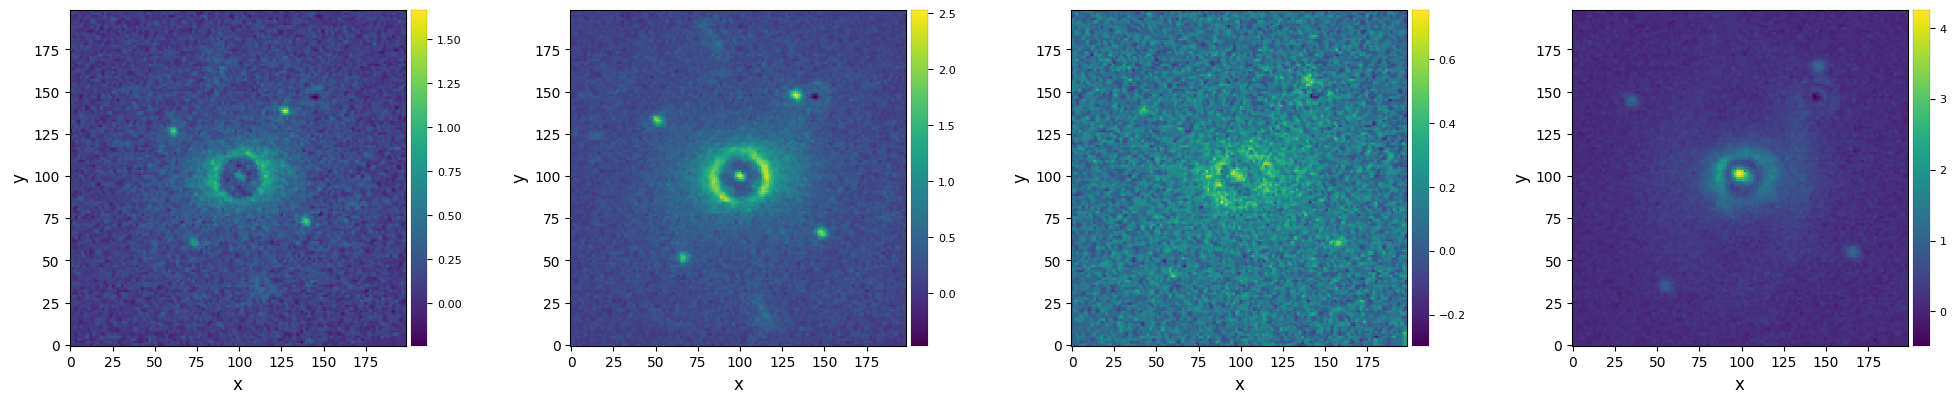

In [48]:
plot_frames((cube[0], cube[13], cube[25], cube[-1]))#, backend='bokeh')


Although the subtraction is not perfect (the Airy ring is not well fitted), it should be enough for the purpose of using the satellite-spots for recentering.

### 2.2.5. Satellite-spot based recentering

In [49]:
xy = ((61,126), (127,138), (73,60), (140,72))

Recentering based on satellite spots is as simple as calling the `cube_recenter_satspots` function, providing the approximate position `xy` of the satellite spots in the *first* spectral channel and the wavelength vector `lbda`.
Depending on your images, you may have to play with the size of the subimages `subi_size` where the 2D fit is peformed, the thresholding (`sigfactor`) or adapt the `fit_type` ('moff' or 'gaus').
Set `debug` to True to actually see each 2D Moffat or Gaussian fit (warning: in this case 4x39 Gaussian fits are performed and shown!).

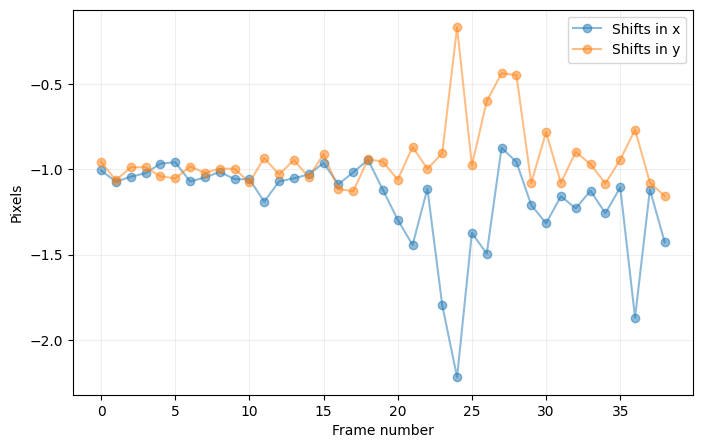

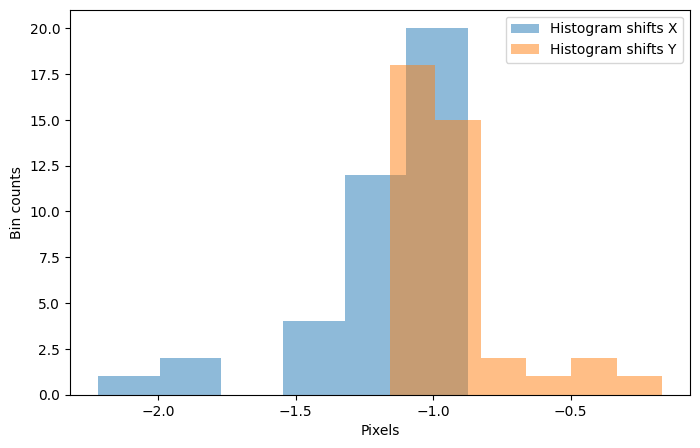

In [50]:
res = cube_recenter_satspots(cube, xy, lbda=lbda, 
                             subi_size=9, sigfactor=0., fit_type='moff', 
                             plot=True, border_mode='constant', 
                             debug=False, verbose=False, full_output=True)
cube_sats, shift_y, shift_x, sat_y, sat_x= res

There appears to be a few outliers. Let's confirm this with the inspection of the central area of each frame:

New shape: (39, 141, 141)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
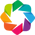

:Dataset   [x,y,time]   (flux)
:Cube_shape	[141, 141, 39]


:DynamicMap   [time]
   :Image   [x,y]   (flux)

In [51]:
from vip_hci.preproc import cube_crop_frames
plot_cubes(cube_crop_frames(cube, 141), backend='bokeh')

Inspection of the corresponding images shows that the flux of the satellite spots is almost null in these channels (in the atmosphere's water absorption band). One can either make the assumption that the shift is the same at all wavelengths, or interpolate from the values found in bright spectral channels.

In [52]:
med_sh_y = np.median(shift_y)
med_sh_x = np.median(shift_x)
print("Median shifts (xy):", med_sh_x, med_sh_y)

Median shifts (xy): -1.0880881852021815 -0.9881898208731315


Note that the same function can be used for recentering of IRDIS images using satellite spots.

### 2.2.6. Radon-transform based recentering

This method relies on the Radon transform, the relevant image transformation to exploit the radial information present in broad-band (or spectrally averaged) images, in order to find the location of the star. More details are available in [Pueyo et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...803...31P/abstract).

In [53]:
mean_fr = np.mean(cube[:30], axis=0) #we skip the last channels where the BKG PSF was the most poorly subtracted

To improve the performance of the Radon-transform based algorithm, it is important to high-pass filter the input frame:

In [54]:
mean_fr_hpf = vip.var.frame_filter_highpass(mean_fr, mode='gauss-subt', fwhm_size = 2*np.mean(fwhm))

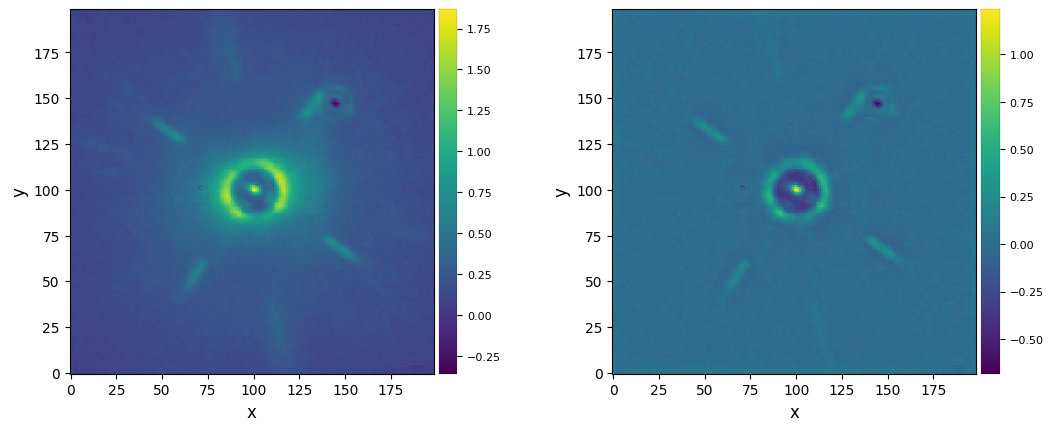

In [55]:
plot_frames((mean_fr,mean_fr_hpf))#, backend='bokeh')

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 12:49:44
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Iteration 1/5 ***


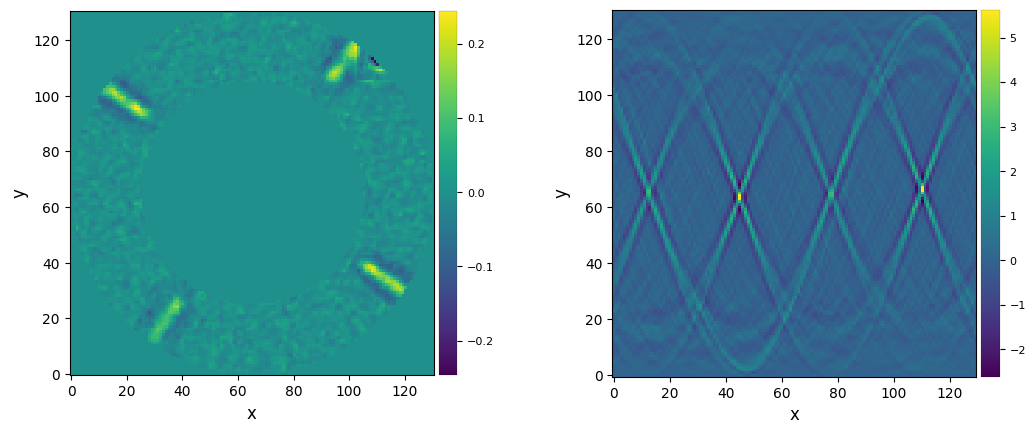

54.723717
Done 961 radon transform calls distributed in 5 processes


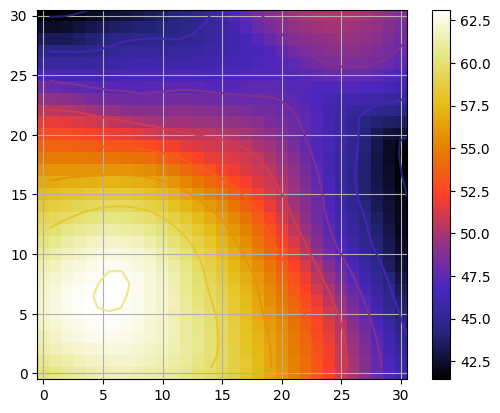

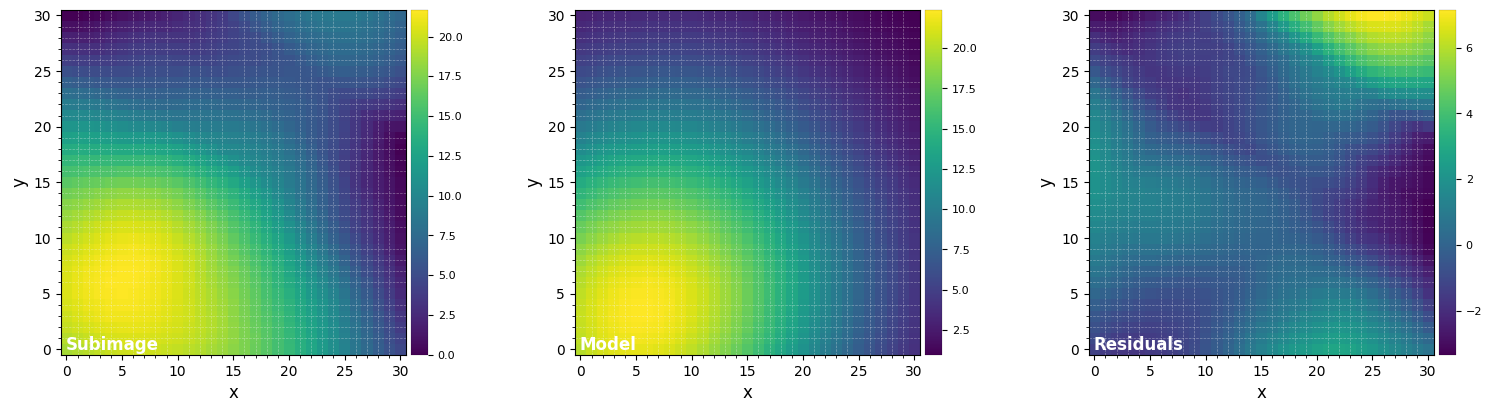

FWHM_y = 33.69007669119456
FWHM_x = 30.487598278892616 

centroid y = 3.6864496643263016
centroid x = 5.616014734789485
centroid y subim = 3.6864496643263016
centroid x subim = 5.616014734789485 

amplitude = 22.393118916398002
theta = -39.7632052946358
Cost function max: 63.122028901098986
Finished grid search radon optimization. dy=-1.131, dx=-0.938
Running time:  0:05:20.294429
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Iteration 2/5 ***


/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:867: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  opt_yind = float(fit_res['centroid_y'])
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:868: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  opt_xind = float(fit_res['centroid_x'])
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:875: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  unc_y = float(fit_res['fwhm_y'])*step
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:876: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  unc_x = float(fit_res['fwhm_x'])*step


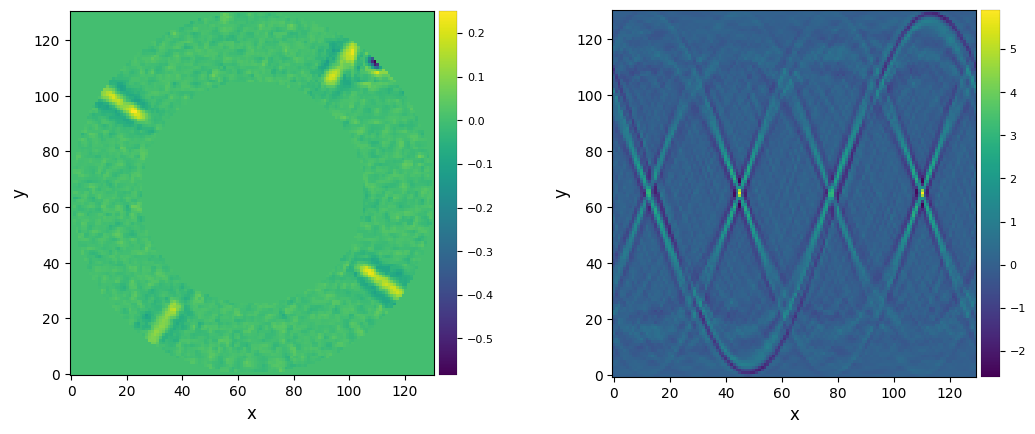

64.45115171265587
Done 441 radon transform calls distributed in 5 processes


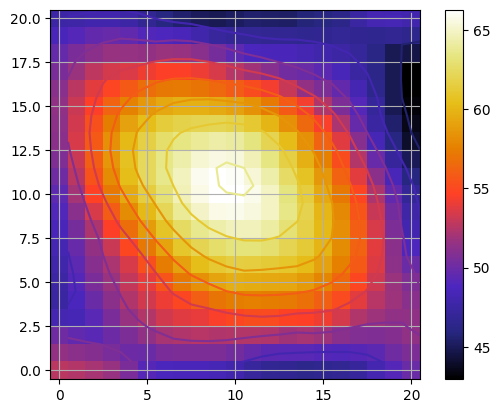

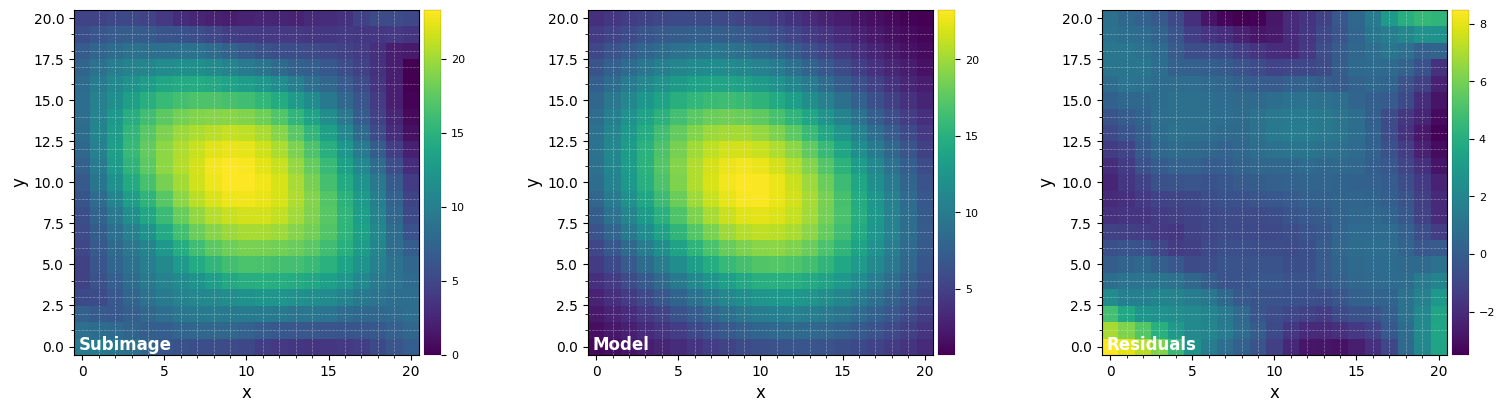

FWHM_y = 12.966413746890785
FWHM_x = 17.539676291220434 

centroid y = 9.758162895449631
centroid x = 9.394438121832279
centroid y subim = 9.758162895449631
centroid x subim = 9.394438121832279 

amplitude = 23.28380114671015
theta = -2373.447966183443
Cost function max: 66.26614397778891
Finished grid search radon optimization. dy=-0.055, dx=-0.137
Running time:  0:07:52.088149
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Iteration 3/5 ***


/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:867: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  opt_yind = float(fit_res['centroid_y'])
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:868: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  opt_xind = float(fit_res['centroid_x'])
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:875: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  unc_y = float(fit_res['fwhm_y'])*step
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:876: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  unc_x = float(fit_res['fwhm_x'])*step


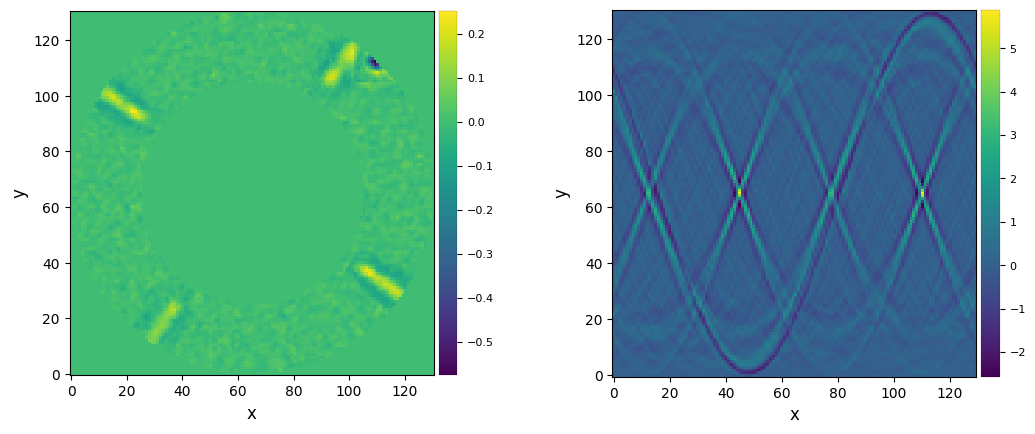

64.40321493770699
Done 441 radon transform calls distributed in 5 processes


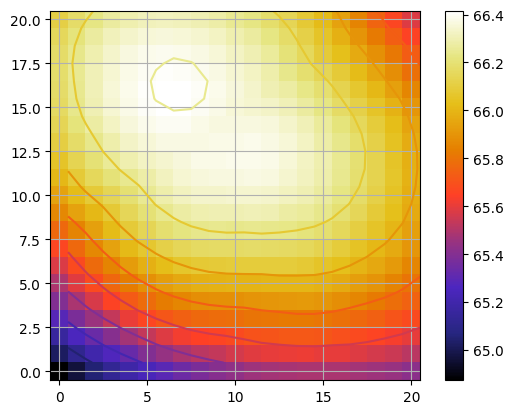

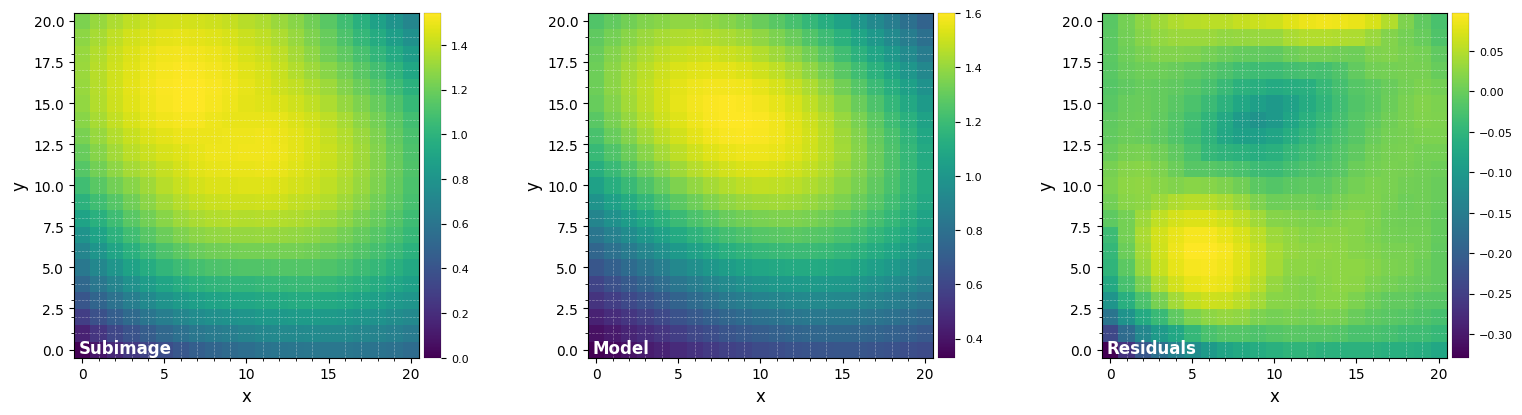

FWHM_y = 21.889499716045716
FWHM_x = 34.46430779987125 

centroid y = 14.246838642661633
centroid x = 8.406958265703716
centroid y subim = 14.246838642661633
centroid x subim = 8.406958265703716 

amplitude = 1.6026806726801428
theta = -208.85855635703444
Cost function max: 66.41620093111999
Finished grid search radon optimization. dy=0.116, dx=-0.044
Running time:  0:10:23.674960
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Iteration 4/5 ***


/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:867: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  opt_yind = float(fit_res['centroid_y'])
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:868: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  opt_xind = float(fit_res['centroid_x'])
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:875: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  unc_y = float(fit_res['fwhm_y'])*step
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:876: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  unc_x = float(fit_res['fwhm_x'])*step


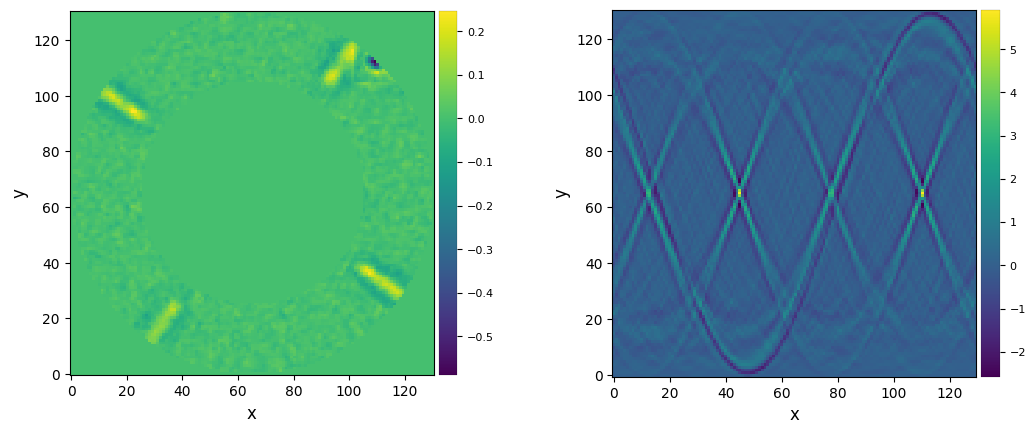

64.47658144369896
Done 441 radon transform calls distributed in 5 processes


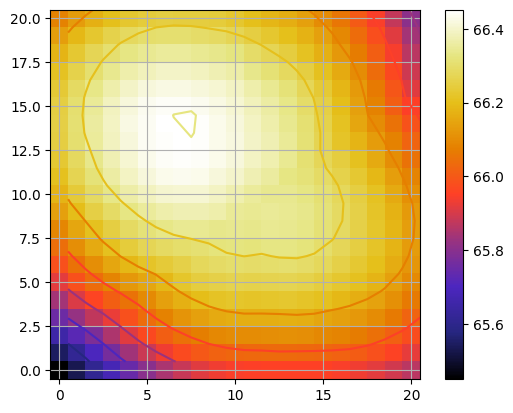

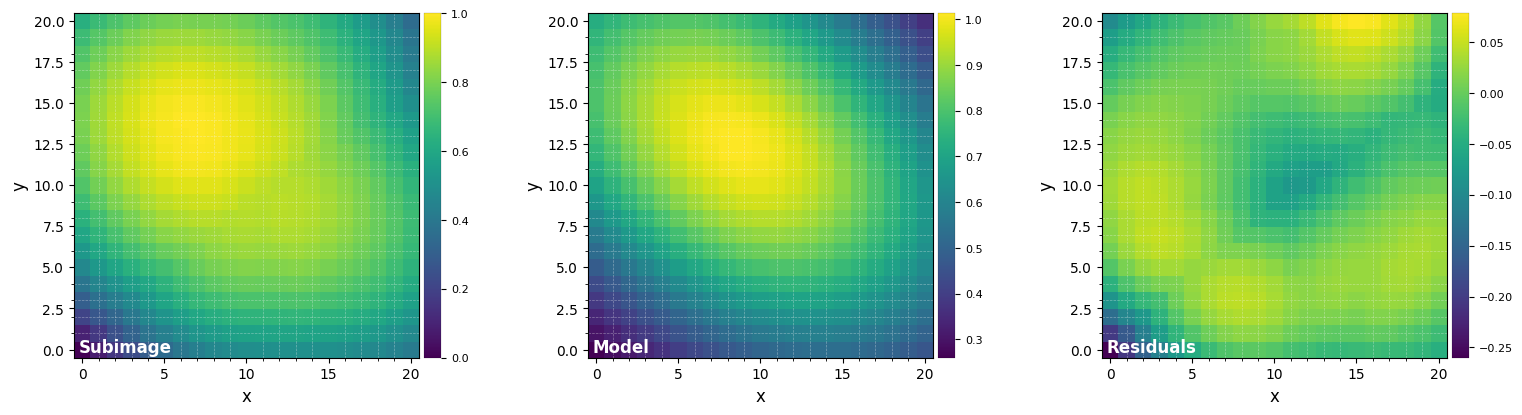

FWHM_y = 21.67736518581785
FWHM_x = 32.73105017083934 

centroid y = 12.5988489345096
centroid x = 8.500879880709359
centroid y subim = 12.5988489345096
centroid x subim = 8.500879880709359 

amplitude = 1.0148216813058595
theta = -216.7595447201716
Cost function max: 66.45192063026184
Finished grid search radon optimization. dy=0.060, dx=-0.035
Running time:  0:12:55.450661
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Iteration 5/5 ***


/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:867: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  opt_yind = float(fit_res['centroid_y'])
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:868: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  opt_xind = float(fit_res['centroid_x'])
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:875: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  unc_y = float(fit_res['fwhm_y'])*step
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:876: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  unc_x = float(fit_res['fwhm_x'])*step


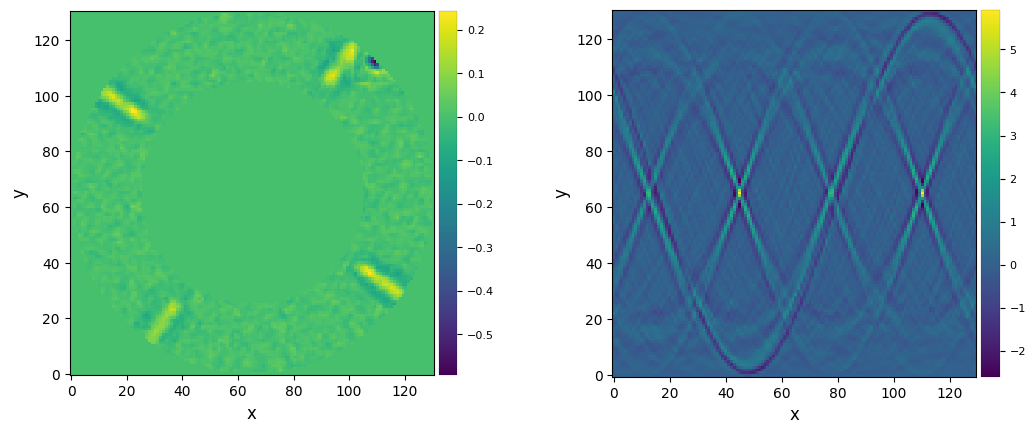

64.46766254569715
Done 441 radon transform calls distributed in 5 processes


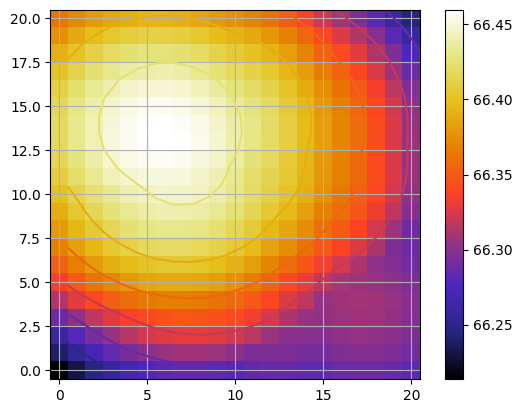

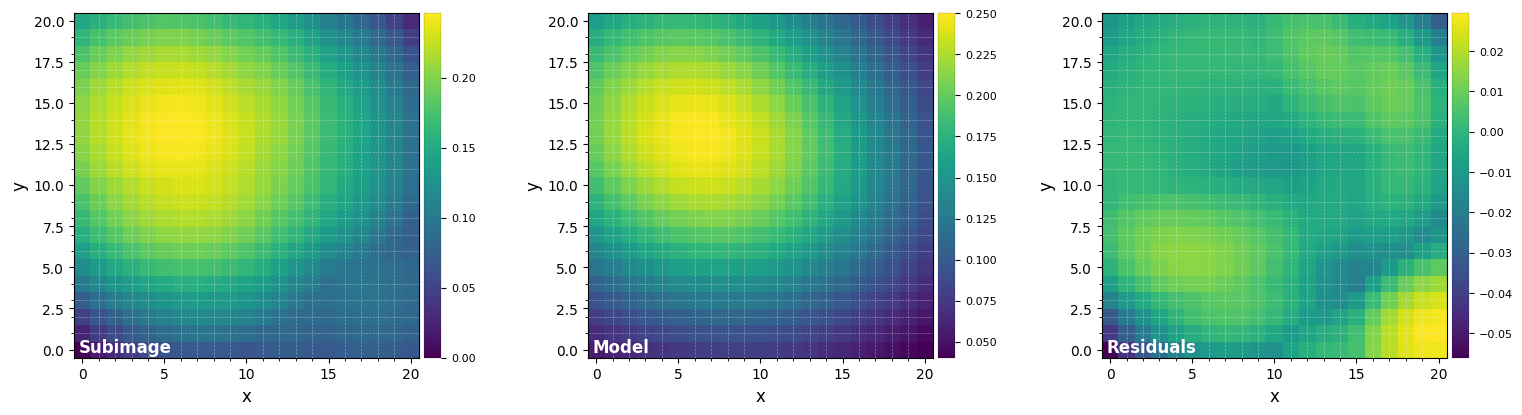

FWHM_y = 19.680447859785534
FWHM_x = 24.17146012453622 

centroid y = 13.046475181777529
centroid x = 6.2585824399101675
centroid y subim = 13.046475181777529
centroid x subim = 6.2585824399101675 

amplitude = 0.2503834291578197
theta = -381.24026864279745
Cost function max: 66.45985446853932
Finished grid search radon optimization. dy=0.037, dx=-0.045
Running time:  0:15:27.062420
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Star (x,y) location: 100.20, 99.97
Final cumulative (x,y) shifts: -1.20, -0.97


/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:867: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  opt_yind = float(fit_res['centroid_y'])
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:868: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  opt_xind = float(fit_res['centroid_x'])
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:875: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  unc_y = float(fit_res['fwhm_y'])*step
/Users/valentin/GitHub/VIP/vip_hci/preproc/recentering.py:876: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  unc_x = float(fit_res['fwhm_x'])*step


In [56]:
opt_y, opt_x = frame_center_radon(mean_fr_hpf, cropsize=131, hsize_ini=1.5, step_ini=0.1, mask_center=40, 
                                  nproc=None, satspots_cfg=None, full_output=False, verbose=True, n_iter=5,
                                  tol=0.05, plot=True, debug=True)

Note that one can increase the precision of the algorithm, by decreasing the `step` used in the grid.

In [57]:
cy, cx = frame_center(mean_fr)

print("Estimated star coordinates (xy):", opt_x, opt_y)
print("Estimated shifts (xy):", cx-opt_x, cy-opt_y)

Estimated star coordinates (xy): 100.1992343743933 99.97234582022708
Estimated shifts (xy): -1.1992343743932992 -0.9723458202270763


As expected, the Radon-transform based algorithm found similar shift values as the satellite-spot based one, since the most prominent features driving the centering are the wavelength-smeared satellite spots.

Once the stellar centroid found, it is only a matter of shifting each frame of the cube with the same xy shifts:

In [58]:
cy, cx = frame_center(mean_fr)
cube = cube_shift(cube_corr, cy-opt_y, cx-opt_x)

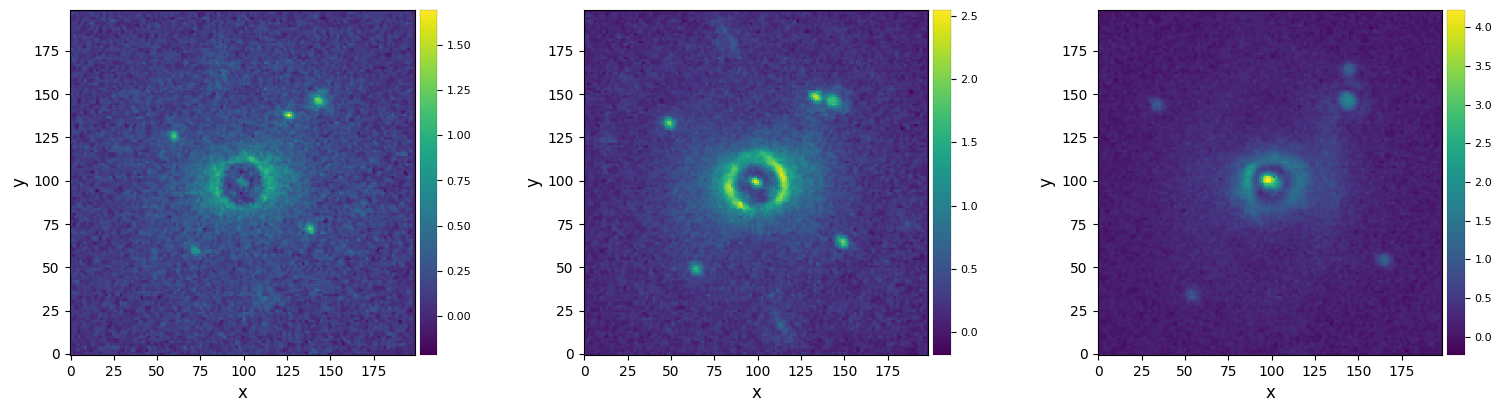

In [59]:
plot_frames((cube[0], cube[15], cube[-1]))#, backend='bokeh')

## 2.3. Pre-processing a SINFONI datacube

### 2.3.1. Loading the data

In the 'datasets' folder of the `VIP_extras` repository you can find a SINFONI datacube obtained on HD 179218 in May 2014. The star did not saturate and no coronagraph was used.

The point of this section is to show how to:

- correct for residual bad pixels in images where the vertical sampling is half of the horizontal sampling;
- resample images vertically;
- perform a fine recentering of the images based on 2D Gaussian fits.

In [60]:
cubename = '../datasets/sinfoni_HD179218_cube.fits'
lbdaname = '../datasets/sinfoni_HD179218_lbda.fits'
cube = open_fits(cubename)
lbda = open_fits(lbdaname)

Fits HDU-0 data successfully loaded, header available. Data shape: (400, 64, 64)
Fits HDU-0 data successfully loaded, header available. Data shape: (400,)


Each original spectral cube consisted of ~2000 monochromatic images spread in wavelengths over the H and K bands.

Given the large size of typical full SINFONI observations, in this tutorial we only include one datacube, obtained after calibration using the ESO pipeline (including dark subtraction, flat-fielding, sky subtraction, wavelength calibration and 3D spectral cube synthesis), and after cropping the cube to only keep the last 400 channels. Note that  the procedure below would be identical with a non-cropped cube.

Let's first visualize a few images from the datacube:

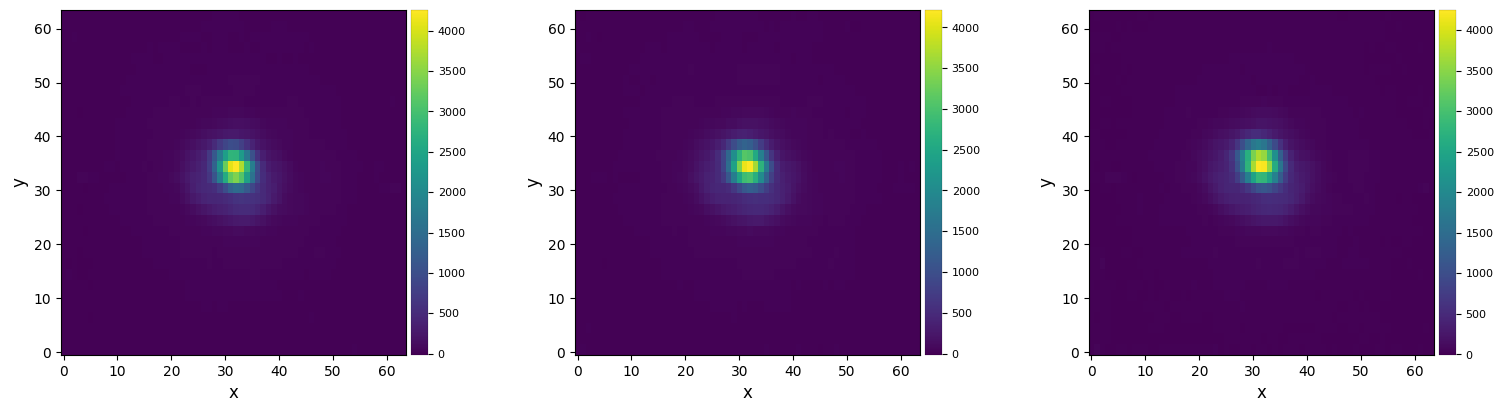

In [61]:
plot_frames((cube[1], cube[200], cube[-1]))

A couple of things can be noted from the inspection of the images:

- the PSF is not centered and expands radially with increasing wavelength;
- the vertical sampling of pixels is half that of the horizontal sampling (i.e. every pair of rows is identical);
- there are bad pixels in the images (best seen with harsher cuts) which tend to come as clumps or horizontal streaks.

We will therefore proceed with:

1. Measuring the FWHM of the PSF in each frame;
2. identifying and correcting bad pixels;
3. resample the images vertically;
4. recenter the cube based on 2D Gaussian fits.

### 2.3.2. FWHM measurement

As seen previously, the FWHM can be easily measured in each frame using the `normalize_psf` function. Let's first consider a 2D Gaussian fit to the mean image, in order to find the average position of the star:

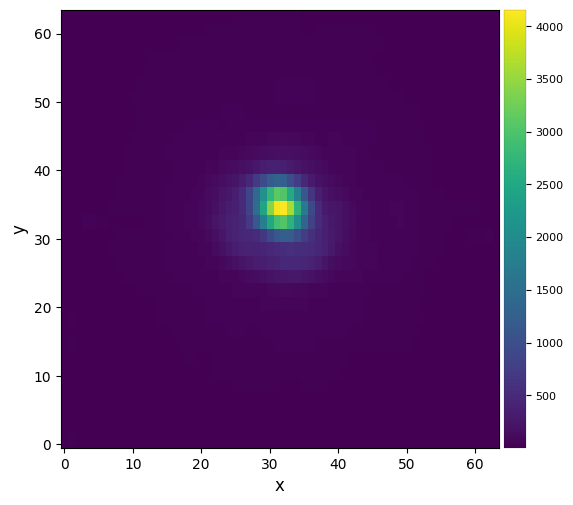

In [62]:
mean_fr = np.mean(cube,axis=0)
plot_frames(mean_fr)#, backend='bokeh')

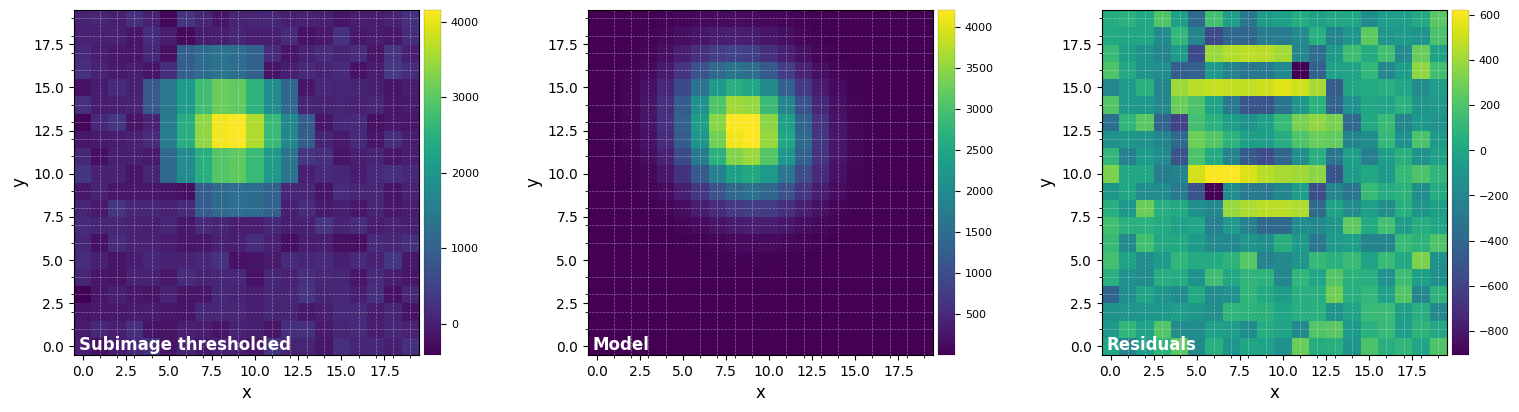

FWHM_y = 5.215838737613178
FWHM_x = 5.993404578115068 

centroid y = 34.54152204255095
centroid x = 31.560580802768364
centroid y subim = 12.541522042550948
centroid x subim = 8.560580802768365 

amplitude = 4374.363394315475
theta = 121.01347985296479


In [63]:
mean_y, mean_x = fit_2dgaussian(mean_fr, crop=True, cent=(33,32), cropsize=20, threshold=True, 
                                sigfactor=5, full_output=False, debug=True)

Now let's consider a sub-cube centered on the mean position, and use `normalize_psf` to measure FWHM and flux:

In [64]:
subcube = cube_crop_frames(cube, size=21, xy=(mean_x, mean_y), force=True) # force cropping to odd size from even size
res = normalize_psf(subcube, fwhm='fit', full_output=True)
norm_psf, fluxes, fwhm = res

New shape: (400, 21, 21)
Mean FWHM per channel: 
[6.585 6.606 6.59  6.593 6.579 6.58  6.594 6.583 6.598 6.591 6.593 6.593
 6.593 6.602 6.588 6.6   6.595 6.61  6.593 6.593 6.602 6.584 6.595 6.606
 6.603 6.598 6.593 6.613 6.593 6.604 6.613 6.61  6.608 6.595 6.609 6.608
 6.594 6.616 6.608 6.625 6.592 6.619 6.625 6.604 6.629 6.605 6.615 6.606
 6.618 6.633 6.602 6.637 6.62  6.636 6.619 6.629 6.619 6.613 6.633 6.615
 6.624 6.634 6.62  6.63  6.618 6.626 6.628 6.621 6.629 6.62  6.631 6.635
 6.627 6.634 6.636 6.629 6.64  6.646 6.646 6.629 6.631 6.633 6.639 6.647
 6.633 6.644 6.645 6.64  6.637 6.627 6.637 6.639 6.638 6.656 6.633 6.663
 6.651 6.641 6.652 6.637 6.656 6.647 6.66  6.64  6.633 6.659 6.667 6.66
 6.654 6.65  6.66  6.652 6.663 6.652 6.655 6.664 6.666 6.664 6.649 6.659
 6.667 6.657 6.662 6.667 6.668 6.675 6.678 6.669 6.668 6.657 6.661 6.666
 6.675 6.663 6.677 6.671 6.68  6.661 6.665 6.678 6.676 6.675 6.676 6.683
 6.669 6.697 6.686 6.687 6.677 6.675 6.68  6.691 6.689 6.698 6.678 6.702
 6.

### 2.3.3. Bad pixel correction

Several bad pixel correction algorithms are available in VIP:

1. `cube_fix_badpix_isolated`: to correct isolated bad pixels by sigma filtering;
2. `cube_fix_badpix_annuli`: which identifies bad pixels in concentric annuli (requires a circularly symmetric PSF), and replace them with the median of the value in the annulus (+ a random value following Poisson distribution);
3. `cube_fix_badpix_clump`: which iteratively identifies bad pixels by sigma filtering, and replace them with the median of good neighour pixels (useful for clumps of bad pixels);
4. `cube_fix_badpix_ifs`: which leverages the radial expanion of the PSF with wavelength in IFS cubes to better identify bad pixels;
5. `cube_fix_badpix_with_kernel`: which corrects bad pixels using a 2D Gaussian kernel (requires an input bad pixel map, possibly found by one of the first 4 methods).

Since bad pixels can show up as clumps or streaks in SINFONI cubes, it is recommended to use either `cube_fix_badpix_annuli` or `cube_fix_badpix_clump` to identify them iteratively. 

In the example below, we will first consider `cube_fix_badpix_annuli` for the identification of bad pixels, and then `cube_fix_badpix_with_kernel` to correct the identified bad pixels using a Gaussian kernel.

If the PSF core spreads over at least a few pixels, there is low risk for the algorithm to erroneously consider a PSF core pixel as bad. In noisy channels, the risk may be non-negligeable though. To prevent this risk, one can use the `protect_mask` parameter (in which case, the coordinates of the star must also be provided through the `cy` and `cx` parameters).  Let's find the approximate stellar position in each frame with the aptly-named `approx_stellar_position` function:

In [65]:
cyx = approx_stellar_position(cube, fwhm)
cy = cyx[:,0]
cx = cyx[:,1]

Let's now set the mask size to the median value of the FWHM:

In [66]:
protect_mask = np.median(fwhm)

Given the peculiar half resolution along the vertical axis of SINFONI cubes, we will also use the `half_res_y` option, which in the case `cube_fix_badpix_annuli` will make it consider elliptical annuli in squashed images (by a factor 2 vertically) - instead of circular annuli.

A minimum threshold `min_thr` can be set to avoid correcting pure noise (which can happen in high-absorption atmospheric bands). Considering the typical pixel intensities in SINFONI cubes and the fact that they are already sky-subtracted images of our SINFONI cube, we opt for a value of -5.

In [67]:
cube_corr, bpm_mask, annuli = cube_fix_badpix_annuli(cube, fwhm, cy=cy, cx=cx, sig=5., 
                                                     protect_mask=protect_mask, r_in_std=10, r_out_std=None, 
                                                     verbose=True, half_res_y=True, min_thr=-5, 
                                                     full_output=True)

************Frame #  0  *************
centroid assumed at coords: 31.0 35.0
0.0  bpix in total, and  0.0  corrected.
************Frame #  1  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  2  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  3  *************
centroid assumed at coords: 31.0 35.0
0.0  bpix in total, and  0.0  corrected.
************Frame #  4  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  5  *************
centroid assumed at coords: 31.0 35.0
0.0  bpix in total, and  0.0  corrected.
************Frame #  6  *************
centroid assumed at coords: 31.0 35.0
0.0  bpix in total, and  0.0  corrected.
************Frame #  7  *************
centroid assumed at coords: 31.0 35.0
0.0  bpix in total, and  0.0  corrected.
************Frame #  8  *************
centroid assumed at coords

0.0  bpix in total, and  0.0  corrected.
************Frame #  87  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  88  *************
centroid assumed at coords: 31.0 35.0
3.0  bpix in total, and  3.0  corrected.
************Frame #  89  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  90  *************
centroid assumed at coords: 31.0 35.0
2.0  bpix in total, and  2.0  corrected.
************Frame #  91  *************
centroid assumed at coords: 31.0 35.0
2.0  bpix in total, and  2.0  corrected.
************Frame #  92  *************
centroid assumed at coords: 31.0 35.0
2.0  bpix in total, and  2.0  corrected.
************Frame #  93  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  94  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Fra

1.0  bpix in total, and  1.0  corrected.
************Frame #  156  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  157  *************
centroid assumed at coords: 31.0 35.0
2.0  bpix in total, and  2.0  corrected.
************Frame #  158  *************
centroid assumed at coords: 31.0 35.0
0.0  bpix in total, and  0.0  corrected.
************Frame #  159  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  160  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  161  *************
centroid assumed at coords: 31.0 35.0
0.0  bpix in total, and  0.0  corrected.
************Frame #  162  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  163  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
*******

0.0  bpix in total, and  0.0  corrected.
************Frame #  242  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  243  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  244  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  245  *************
centroid assumed at coords: 31.0 35.0
0.0  bpix in total, and  0.0  corrected.
************Frame #  246  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
************Frame #  247  *************
centroid assumed at coords: 31.0 35.0
3.0  bpix in total, and  3.0  corrected.
************Frame #  248  *************
centroid assumed at coords: 31.0 35.0
3.0  bpix in total, and  3.0  corrected.
************Frame #  249  *************
centroid assumed at coords: 31.0 35.0
0.0  bpix in total, and  0.0  corrected.
*******

1.0  bpix in total, and  1.0  corrected.
************Frame #  314  *************
centroid assumed at coords: 31.0 35.0
3.0  bpix in total, and  3.0  corrected.
************Frame #  315  *************
centroid assumed at coords: 31.0 35.0
2.0  bpix in total, and  2.0  corrected.
************Frame #  316  *************
centroid assumed at coords: 31.0 35.0
2.0  bpix in total, and  2.0  corrected.
************Frame #  317  *************
centroid assumed at coords: 31.0 35.0
0.0  bpix in total, and  0.0  corrected.
************Frame #  318  *************
centroid assumed at coords: 31.0 35.0
0.0  bpix in total, and  0.0  corrected.
************Frame #  319  *************
centroid assumed at coords: 31.0 35.0
2.0  bpix in total, and  2.0  corrected.
************Frame #  320  *************
centroid assumed at coords: 31.0 35.0
4.0  bpix in total, and  4.0  corrected.
************Frame #  321  *************
centroid assumed at coords: 31.0 35.0
1.0  bpix in total, and  1.0  corrected.
*******

1.0  bpix in total, and  1.0  corrected.
************Frame #  387  *************
centroid assumed at coords: 31.0 35.0
2.0  bpix in total, and  2.0  corrected.
************Frame #  388  *************
centroid assumed at coords: 31.0 35.0
4.0  bpix in total, and  4.0  corrected.
************Frame #  389  *************
centroid assumed at coords: 31.0 35.0
5.0  bpix in total, and  5.0  corrected.
************Frame #  390  *************
centroid assumed at coords: 31.0 35.0
2.0  bpix in total, and  2.0  corrected.
************Frame #  391  *************
centroid assumed at coords: 31.0 35.0
2.0  bpix in total, and  2.0  corrected.
************Frame #  392  *************
centroid assumed at coords: 31.0 35.0
0.0  bpix in total, and  0.0  corrected.
************Frame #  393  *************
centroid assumed at coords: 31.0 35.0
0.0  bpix in total, and  0.0  corrected.
************Frame #  394  *************
centroid assumed at coords: 31.0 35.0
2.0  bpix in total, and  2.0  corrected.
*******

Let's visualize the total bad pixel maps (i.e. summed over all spectral channels), and an example of concentric annuli in which bad pixels are identified.

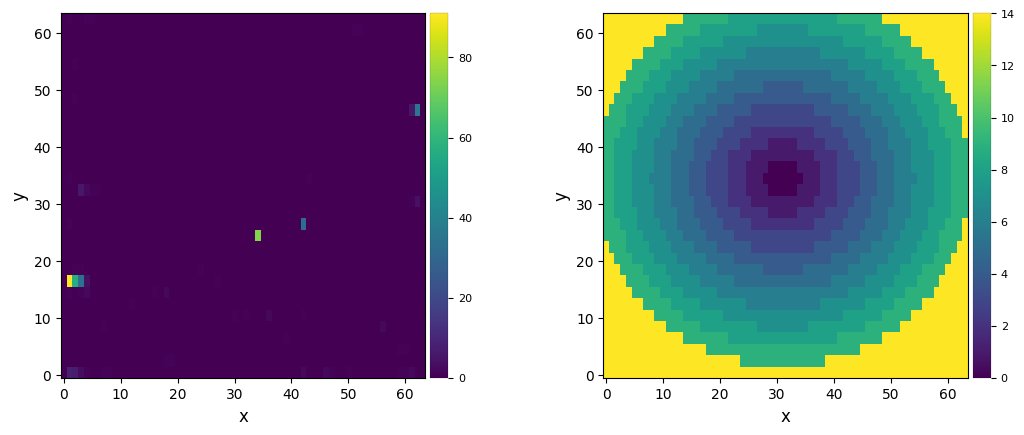

In [68]:
plot_frames((np.sum(bpm_mask,axis=0), annuli[0]))

Let's now check one frame of the cube before and after bad pixel correction (we saturate a bit the core to better see the bad pixel):

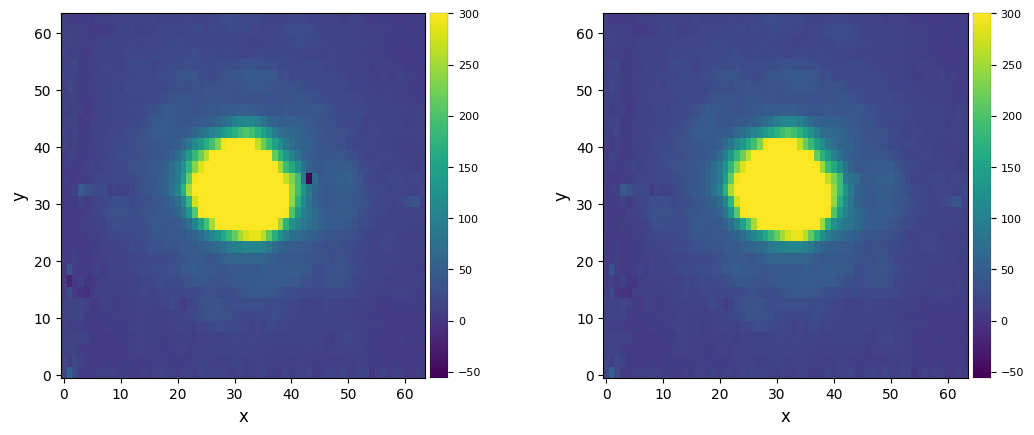

In [69]:
idx = 236
plot_frames((cube[idx], cube_corr[idx]), 
            vmin=float(np.amin(cube[idx])), vmax=300)

Let's now consider a Gaussian kernel for correction of the identified bad pixels. Note that for a better correction locally, we choose the FWHM of the Gaussian kernel to be half the FWHM of the PSF:

In [70]:
if version.parse(vvip) >= version.parse("1.3.1"):
    cube_corr = cube_fix_badpix_interp(cube, bpm_mask, mode='gauss', fwhm=fwhm/2., half_res_y=True)
else:
    cube_corr = cube_fix_badpix_with_kernel(cube, bpm_mask, mode='gauss', fwhm=fwhm/2., half_res_y=True)

Let's check again the same frame of the cube, before and after bad pixel correction with the Gaussian kernel, and the difference between them:

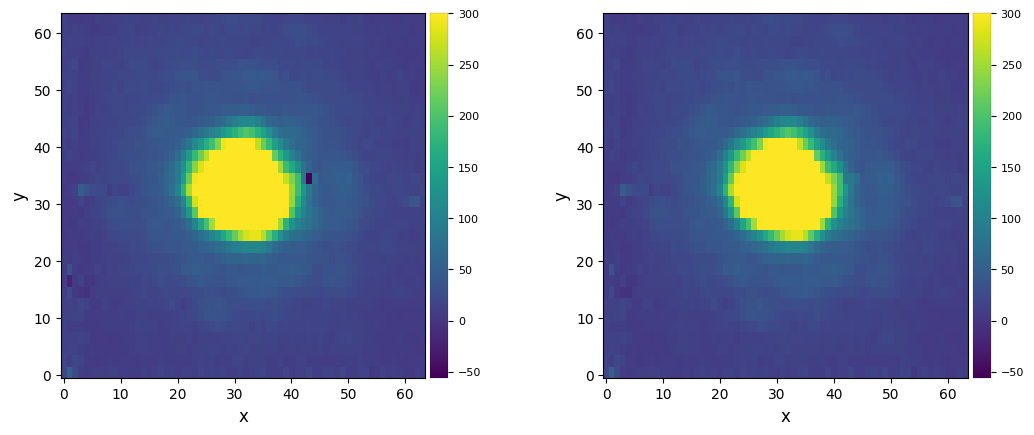

In [71]:
idx = 236
plot_frames((cube[idx], cube_corr[idx]), 
            vmin=float(np.amin(cube[idx])), vmax=300)

In this specific case, it is unclear which of the annulus-based or Gaussian kernel-based correction leads to the best correction. Keep however in mind that the best options to use for bad pixel correction will depend on your data.

### 2.3.4. Vertical resampling

Now that bad pixels are corrected, we can resample the images vertically. This can be done easily with the `cube_px_resampling` function. Before that, we first downsample the image vertically by a factor 2 (since every pair of rows is identical):

In [72]:
nz, ny, nx = cube.shape
# downsample
nny = ny//2
cube_do = np.zeros([nz, nny, nx])
for z in range(nz):
    for y in range(nny):
        cube_do[z,y] = 2*cube_corr[z,y*2]
# Note: factor 2 is for flux preservation since we are only keeping every other row.

Now let's upsample by a factor 2. It is possible to preserve the star at the center of the image with the `keep_center` option (i.e. the star centroid will continue to follow VIP's convention of being at dim//2, dim//2 even when the resampling factor converts the image from even dimensions to odd dimensions). Since the star is not yet centered, we do not use that option. The `scale` parameter can be a float (identical factor along both x and y axes) or a tuple of two values.

In [73]:
# upsample        
cube_up = cube_px_resampling(cube_do, scale=(1,2), imlib='opencv', interpolation='lanczos4', keep_center=False, 
                             verbose=True)

Cube successfully rescaled
New shape: (400, 64, 64)


Note that we used 'opencv' instead of the default 'vip-fft' for the value of `imlib` because FFT-based image scaling is not (yet) available in the case of different scale factors along x and y.

### 2.3.5. Recentering with 2D Gaussian fits

Now that the images have been correctly resampled vertically, we can accurately find the centroid of the star by fitting 2D Gaussians to each image: 

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2023-08-01 13:05:26
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.637214
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


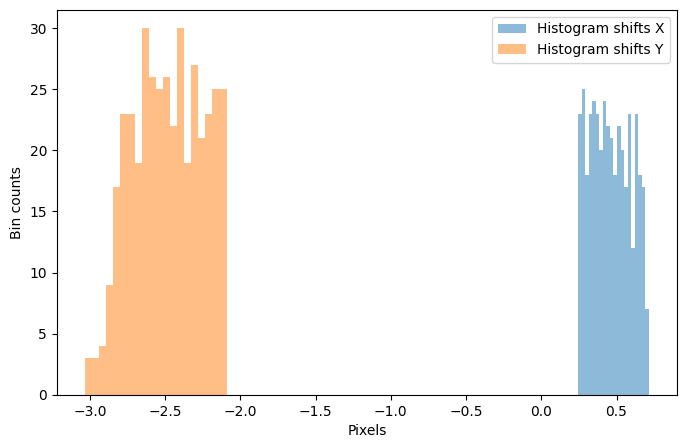

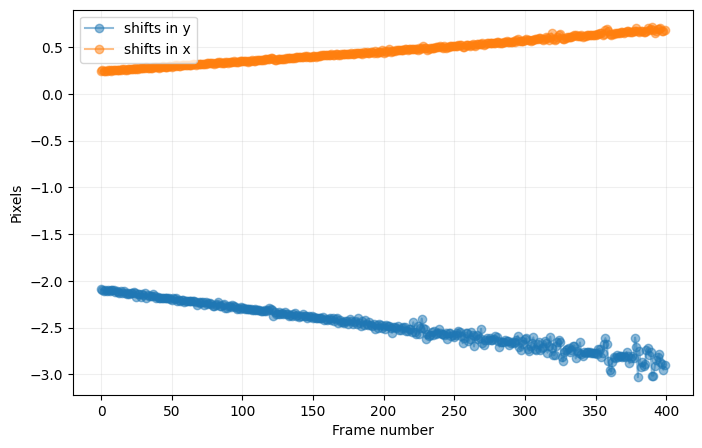

In [74]:
crop_sz = 20
nproc = None
cube_cen, shifts_y, shifts_x = cube_recenter_2dfit(cube_up, xy=(int(mean_x), int(mean_y)), 
                                               fwhm=fwhm, subi_size=crop_sz,
                                               model='gauss', nproc=nproc, 
                                               imlib='vip-fft', interpolation=None,
                                               full_output=True, plot=True)
                                                 

Let's compare the images before and after resampling+recentering:

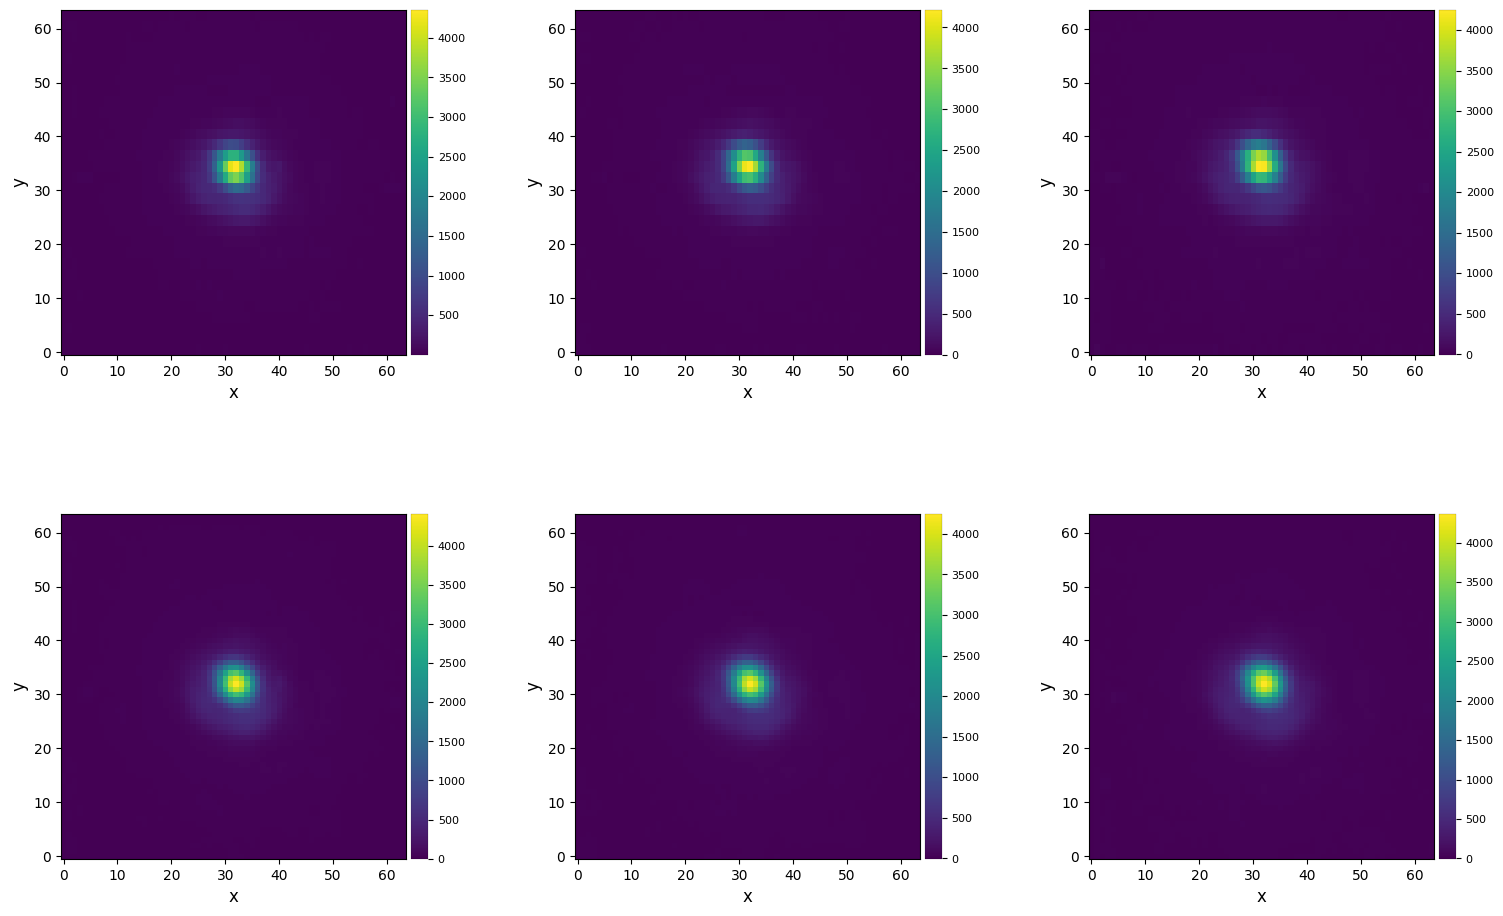

In [75]:
plot_frames((cube_corr[0], cube_corr[200], cube_corr[-1],
             cube_cen[0], cube_cen[200], cube_cen[-1]), rows=2)

Finally it is worth noting that this pre-processing procedure can be further refined now that the star location is known - e.g. by correcting residual bad pixels using `cube_fix_badpix_ifs` which requires realigned cubes and knowledge of the star location.